# Spaceship Titanic - Detailierte EDA, NaN-Imputation und Modelierung

![hi](Pictures/Titanic.png) 

*Spaceship Titanic von* [*Doctor Who, Story 189*](https://tardismusings.blogspot.com/2018/01/story-189-voyage-of-damned.html)


<br>

Das folgende Notebook stellt meinen persönlichen Ansatz zur statistischen Analyse des Datensatzes dar, der in der Spaceship Titanic Kaggle Challenge bereitgestellt wurde. Im Rahmen der Analyse werden wir nicht nur die bereitgestellten Merkmale alleine betrachten, sondern auch Beziehungen zwischen Variablen entdecken, neue Merkmale entwickeln und verschiedene Strategien zur Auffüllung fehlender Werte im Datensatz untersuchen. Ich werde sehr ausführlich beschreiben, was ich analysiere, welche Erkenntnisse die verschiedenen Diagramme liefern, warum ich bestimmte Werte für die Imputation fehlender Daten wähle, usw.

Das Ziel des gesamten Prozesses ist es, ein tiefes Verständnis der verschiedenen Merkmale zu gewinnen und natürlich den Datensatz zu bereinigen, bevor wir damit beginnen, Modelle zur Vorhersage der Zielvariable 'Transported' zu entwickeln. Der Modellierungsprozess selbst ist nicht das Hauptziel dieses Notebooks. Am Ende, in Abschnitt 5, werde ich jedoch auch zwei Beispiel-Baseline-Ensemble-Modelle behandeln, einen RandomForest und einen GradientBoostingClassifier, die beide **über 80%** auf den Testdaten erzielen. 
<br> 
<br> 

Das Notebook:


1. [**Packete importieren und Daten laden**](#Section1)
2. [**Gesamtübersicht**](#Section2)
3. [**Bivariate und multivariate Analyse**](#Section2.1)
4. [**Daten vorverarbeiten und fehlende Werte behandeln**](#Section3)
5. [**Trainieren von Baseline-Modelle**](#Section5)
<br>


<br>
<a id="Section1"></a>

# 1. Packete importieren und Daten laden

### 1.1 Packete importieren

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from SupportFunctions import annotate_bar_perc

### 1.2 Daten laden

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

<a id="Section2"></a>

## 2. Gesamtübersicht 

In diesem Teil der Analyse werden wir folgendes betrachten:

- die Merkmale,
- ihre univariate Verteilung in Bezug auf die Zielvariable,
- NaN-Werte
- mögliche offensichtliche Korrelationen.

### 2.1 Beschreibung des Datensatzes

**train.csv** - Persönliche Aufzeichnungen für etwa zwei Drittel (~8700) der Passagiere, die als Trainingsdaten verwendet werden sollen.

1. **PassengerId** - Eine eindeutige ID für jeden Passagier. Jede ID hat die Form gggg_pp, wobei gggg eine Gruppe angibt, mit der der Passagier reist, und pp ist seine Nummer innerhalb der Gruppe. Personen in einer Gruppe sind oft Familienmitglieder, aber nicht immer.

2. **HomePlanet** - Der Planet, von dem der Passagier abgereist ist, ist in der Regel ihr Heimatplanet, also der Ort ihres Wohnsitzes.

3. **CryoSleep** - Gibt an, ob der Passagier sich dafür entschieden hat, für die Dauer der Reise in Kälteschlaf versetzt zu werden. Passagiere im Kälteschlaf sind in ihren Kabinen eingeschlossen.

4. **Cabin** - Die Kabinennummer, in der der Passagier untergebracht ist. Hat die Form Deck/Nummer/Seite, wobei die Seite entweder P für Backbord oder S für Steuerbord sein kann.

5. **Destination** - Der Planet, auf dem der Passagier von Bord gehen wird.

6. **Age** - Das Alter des Passagiers.

7. **VIP** - Ob der Passagier für einen besonderen VIP-Service während der Reise bezahlt hat.

8. **RoomService** - Der Betrag, für Luxusangebot an Bord der Spaceship Titanic.

9. **FoodCourt** - Der Betrag, für Luxusangebot an Bord der Spaceship Titanic. 

10. **ShoppingMall** - Der Betrag, für Luxusangebot an Bord der Spaceship Titanic. 

11. **Spa** - Der Betrag, für Luxusangebot an Bord der Spaceship Titanic..

12. **VRDeck** - Der Betrag, für Luxusangebot an Bord der Spaceship Titanic.

13. **Name** - Der Vor- und Nachname des Passagiers.

14. **Transported** - Ob der Passagier in eine andere Dimension transportiert wurde. Dies ist die Zielvariable, die Spalte, die du zu prognostizieren versuchst.

---
**test.csv** - Persönliche Aufzeichnungen für das verbleibende Drittel (~4300) der Passagiere, die als Testdaten verwendet werden sollen. Die Aufgabe ist es, den Wert "Transported" für die Passagiere in diesem Satz vorherzusagen. 



In [3]:
# Zeige die ersten Zeilen des Trainingsdatensatzes an
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [4]:
# Zeige Informationen über den Trainingsdatensatz an
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# Wir sehen, dass CryoSleep und VIP boolesche Werte enthalten, aber als Objekte gespeichert sind.
# Wir müssen sie für spätere Analysen umwandeln.
train[["CryoSleep", "VIP"]] = train[["CryoSleep", "VIP"]].astype("boolean")

In [6]:
# Zeige Beschreibung aller numerischen Merkmale an
train.describe(include=float).applymap(lambda x: f"{x:0.2f}") # Runde auf 2 Nachkommastellen

C:\Users\bbind\AppData\Local\Temp\ipykernel_1252\267801423.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train.describe(include=float).applymap(lambda x: f"{x:0.2f}") # Runde auf 2 Nachkommastellen


Age RoomService FoodCourt ShoppingMall       Spa    VRDeck
count  8514.00     8512.00   8510.00      8485.00   8510.00   8505.00
mean     28.83      224.69    458.08       173.73    311.14    304.85
std      14.49      666.72   1611.49       604.70   1136.71   1145.72
min       0.00        0.00      0.00         0.00      0.00      0.00
25%      19.00        0.00      0.00         0.00      0.00      0.00
50%      27.00        0.00      0.00         0.00      0.00      0.00
75%      38.00       47.00     76.00        27.00     59.00     46.00
max      79.00    14327.00  29813.00     23492.00  22408.00  24133.00

In [7]:
# Zeige alle kategorischen und booleschen Merkmale an
train.describe(include=[object, bool])

PassengerId HomePlanet CryoSleep    Cabin  Destination    VIP  \
count         8693       8492      8476     8494         8511   8490   
unique        8693          3         2     6560            3      2   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e  False   
freq             1       4602      5439        8         5915   8291   

                  Name Transported  
count             8493        8693  
unique            8473           2  
top     Gollux Reedall        True  
freq                 2        4378

**Zielvariable**

In der folgenden Grafik ist zusehen, dass der Datensatz im Hinblick auf die Zielvariable "Transported" ausgeglichen ist.

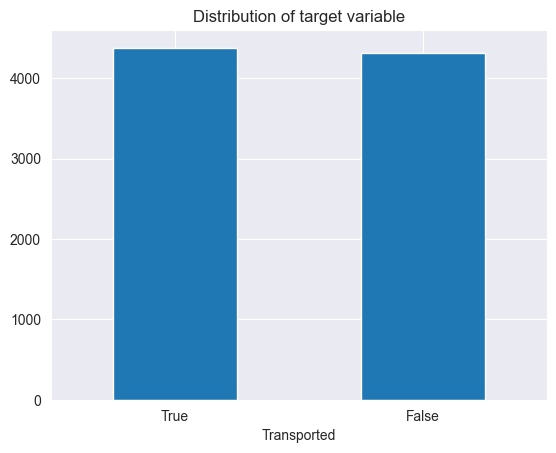

In [8]:
train.Transported.value_counts().plot(kind="bar", title="Distribution of target variable", xlabel="Transported", rot=0)
plt.show()

**Farbkodierter Pairplot der numerischen Daten**

Nun einen Blick auf die numerischen Spalten als Ganzes werfen, indem ein Pairplot verwendet wird und die Datenpunkte einfärben nach ihrem jeweiligen Transportstatus einfärben. Wie aus der folgenden Grafik zusehen ist, sind die Spalten, die sich auf die Ausgaben auf dem Deck beziehen, stark nach rechts verzerrt. Es gibt also viele 0/niedrige Ausgaben und einige sehr hohe Ausreißer. Da diese Daten Spalten darstellen, die streng positive Beträge darstellen, kann eine eine Log-Transformation durchführen, um einen besseren Überblick über mögliche Unterschiede in der Verteilung der Ausgaben von "Transported" und "Non-Transported" Gästen zu bekommen.

C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

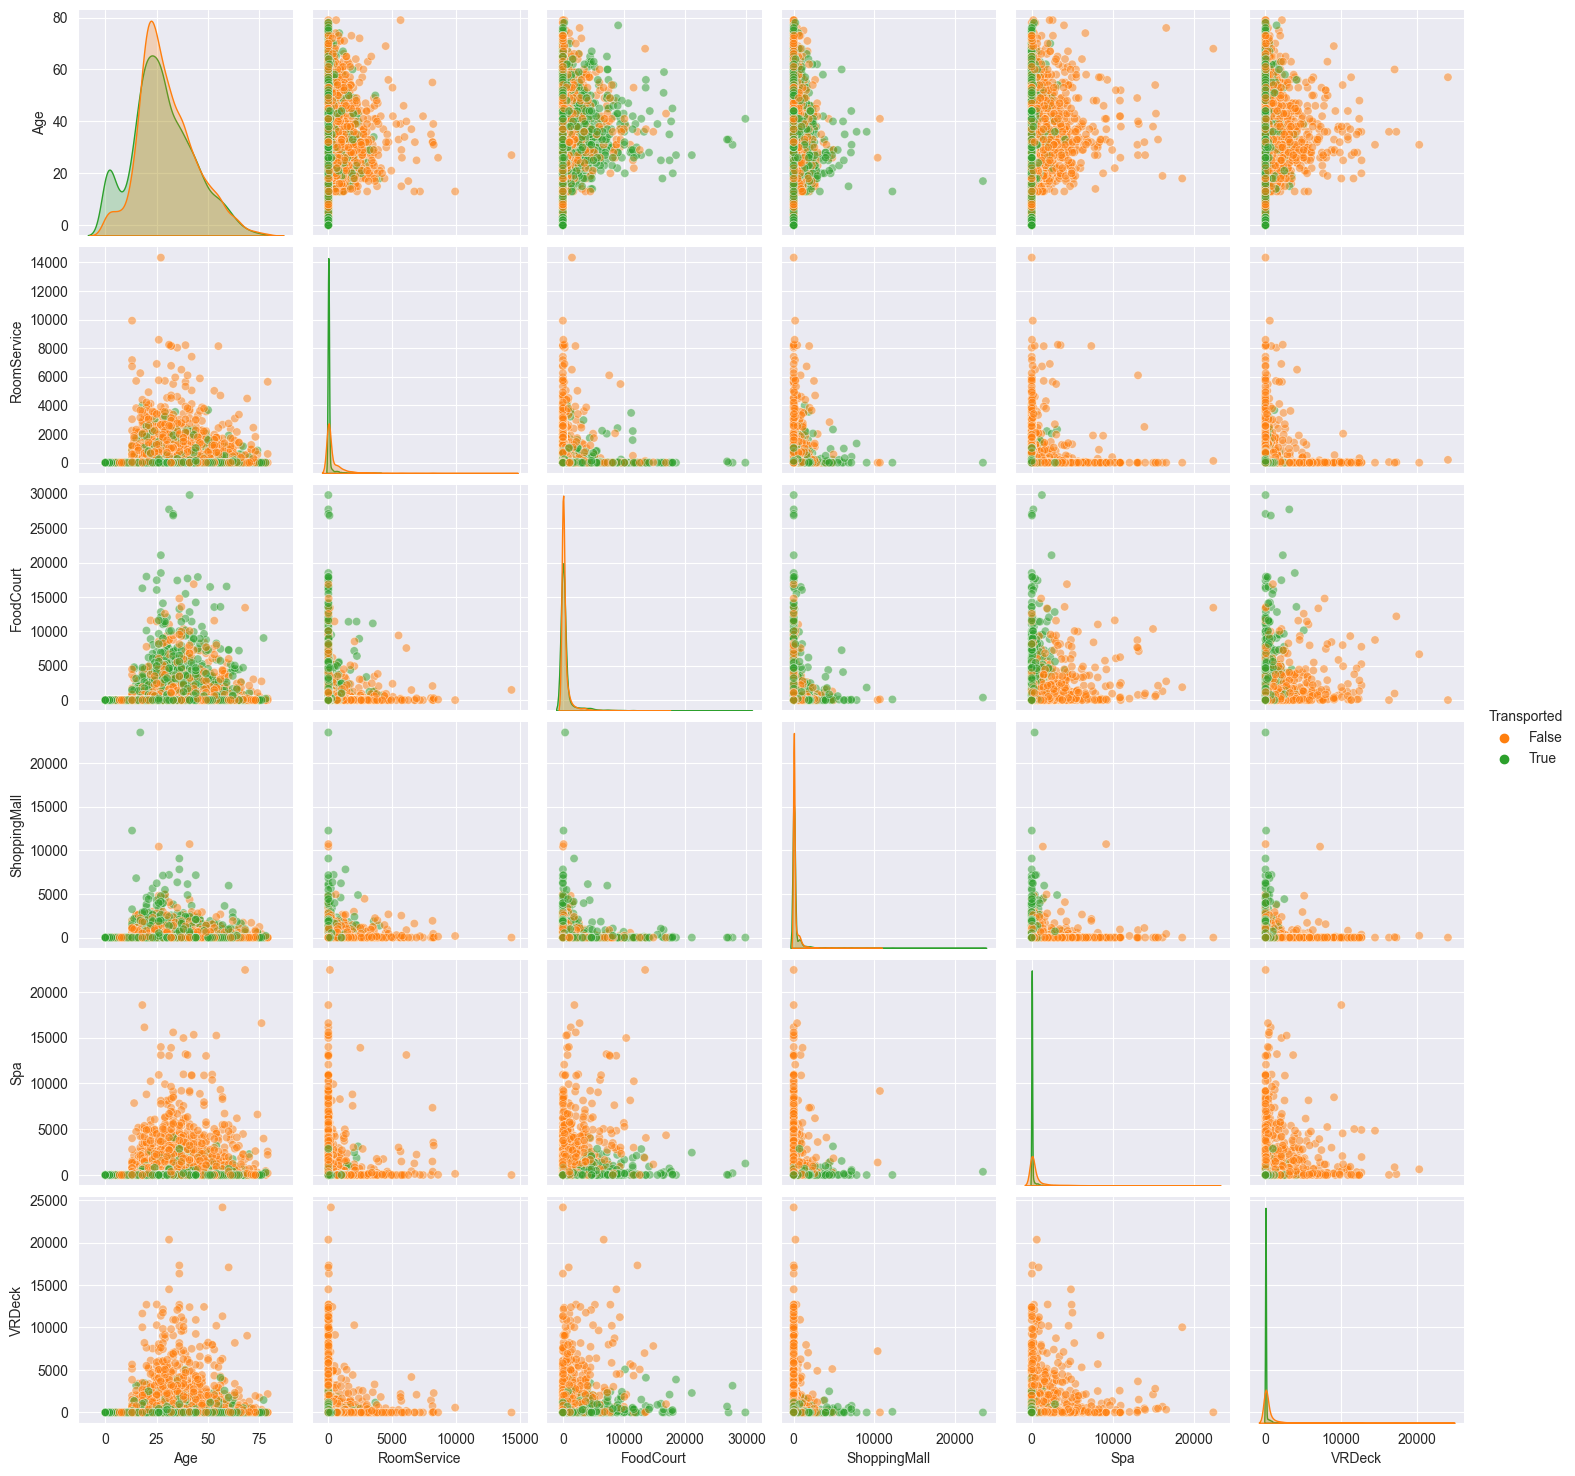

In [9]:
sns.pairplot(train.drop(["CryoSleep", "VIP"],axis=1), hue="Transported", palette=["C1", "C2"], 
             kind="scatter",
             diag_kind="kde",
             plot_kws={"alpha": 0.5})
plt.show()

C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

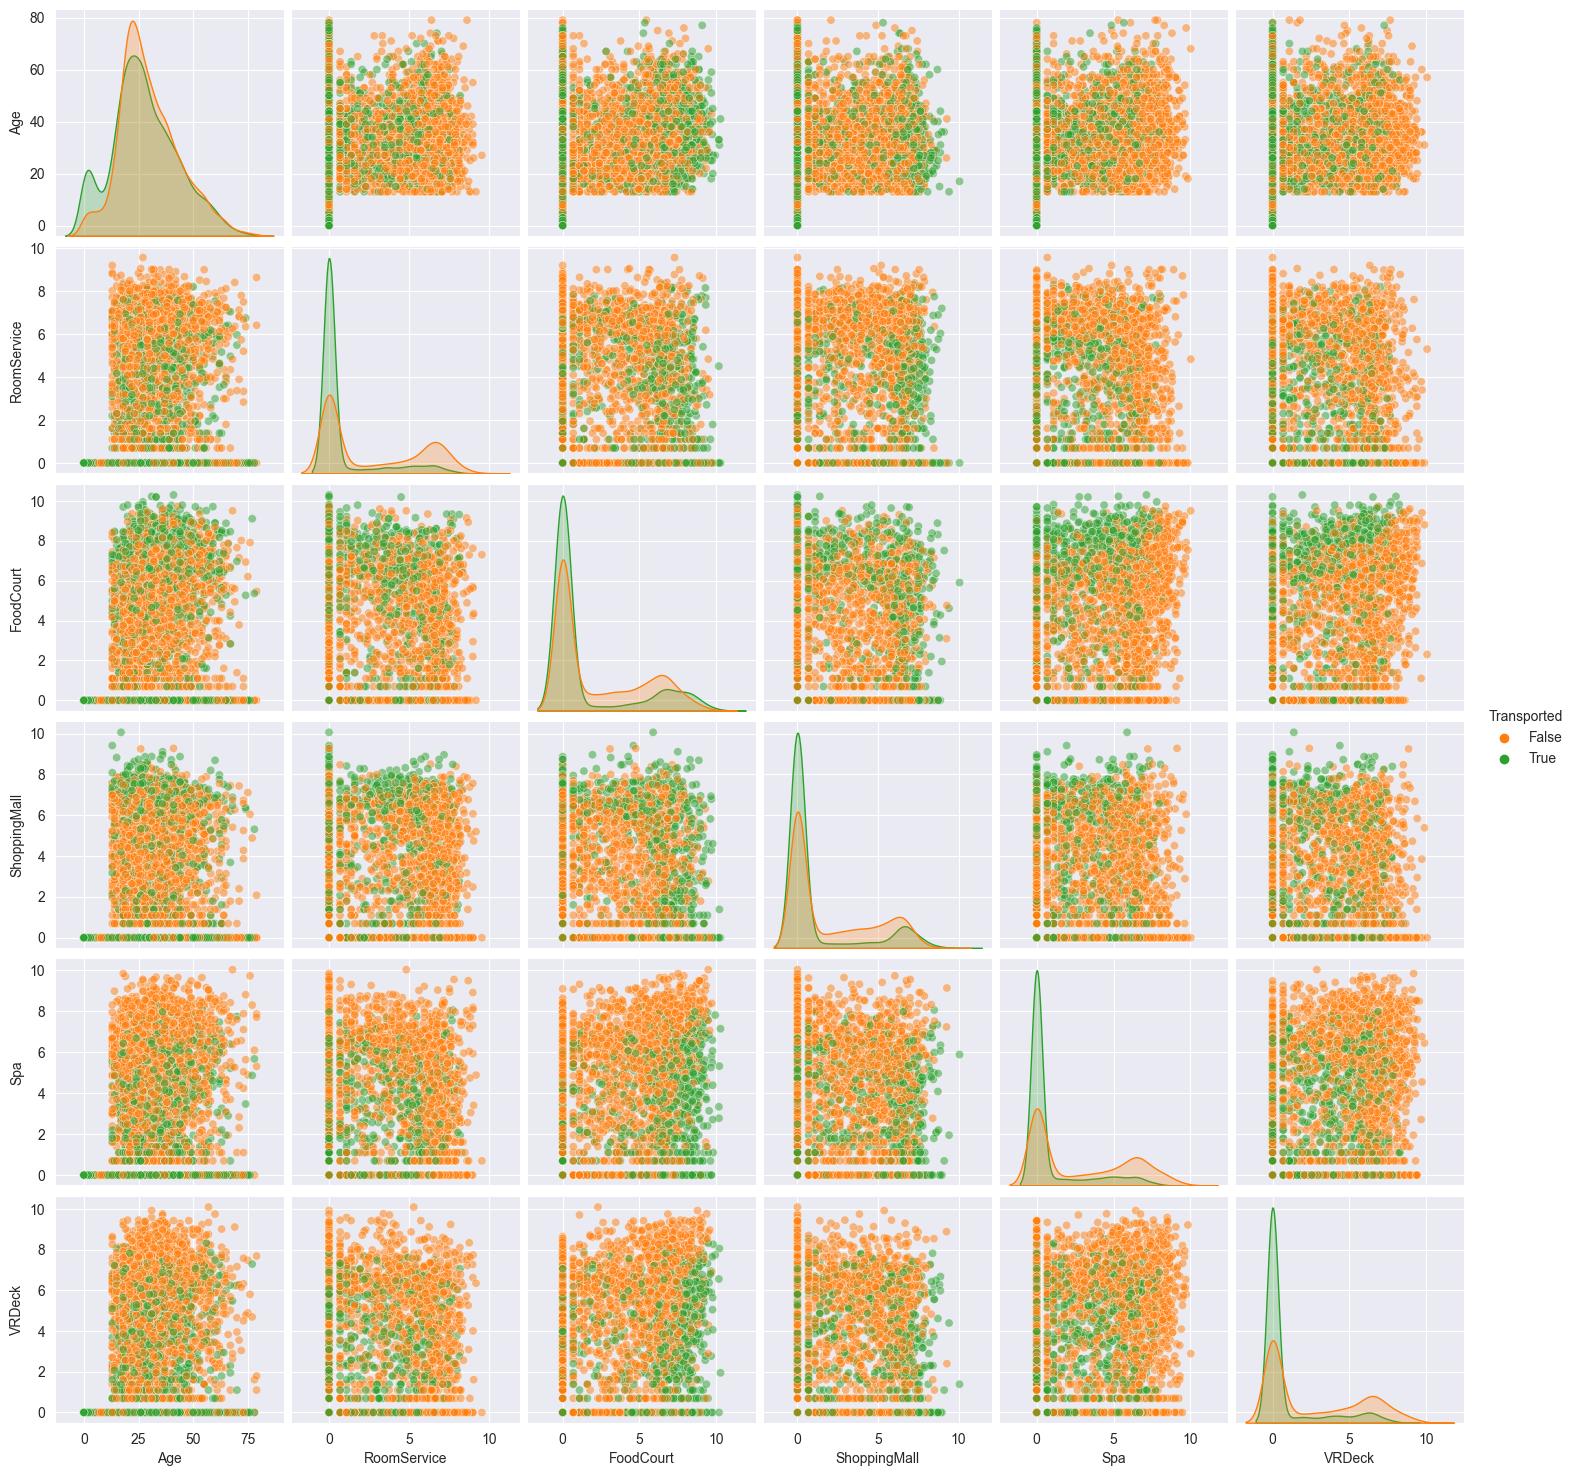

In [10]:
# Log-transform Daten und Pairplot
log_train = train.copy()
to_log_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

log_train[to_log_cols] = log_train[to_log_cols].apply(lambda col: np.log(col+1), raw=True, axis=1)

sns.pairplot(log_train.drop(["CryoSleep", "VIP"],axis=1), hue="Transported", palette=["C1", "C2"], 
             kind="scatter",
             diag_kind="kde",
             plot_kws={"alpha": 0.5})
plt.show()

Aus dem ersten Überblick über die diagonalen Elemente kann man schließen, dass Gäste, die transportiert wurden, eine höhere Wahrscheinlichkeitsmasse in ihren KDE-Plots bei niedrigeren Ausgaben haben. Umgekehrt sehen wir, dass Gäste, die nicht transportiert wurden, eine höhere Wahrscheinlichkeitsmasse bei höheren Ausgaben haben. Es könnte also eine kausale Beziehung zwischen der Zielvariable und der Höhe des Geldes bestehen, das die Leute auf dem Deck ausgeben. Gäste mit höheren Budgets scheinen weniger wahrscheinlich transportiert zu werden. Dies sollte später in der Analyse genauer untersucht werden und auch mit dem VIP-Status in Verbindung gebracht werden.

Alle anderen Scatterplots sind zu unübersichtlich, um aus diesem kleinen Überblick Erkenntnisse zu gewinnen. Generell wird es interessant sein zu analysieren, ob es Beziehungen zwischen den Ausgabenkategorien gibt (z.B. Personen, die den Zimmerservice nutzen, essen weniger am Imbissstand, ...) oder ob es keine interessanten Beziehungen gibt und es ausreicht, nur die Gesamtausgaben als die Summe aller Ausgaben auf dem Deck zu betrachten.

### 2.2 Eindimensionale Visualisierungen

Hier wird jede univariate Verteilung der Merkmale in Abhängigkeit von der Zielvariable visualisiert.

Vor Beginn, fügt man die Spalte "TotalExp" (Gesamtausgaben) als Summe aller Ausgaben hinzu.

In [11]:
train["TotalExp"] = train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(1)


#### 2.2.1 Numerische Merkmale

C:\Users\bbind\AppData\Local\Temp\ipykernel_1252\3534931048.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train, x="Age", hue="Transported", shade=True)
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

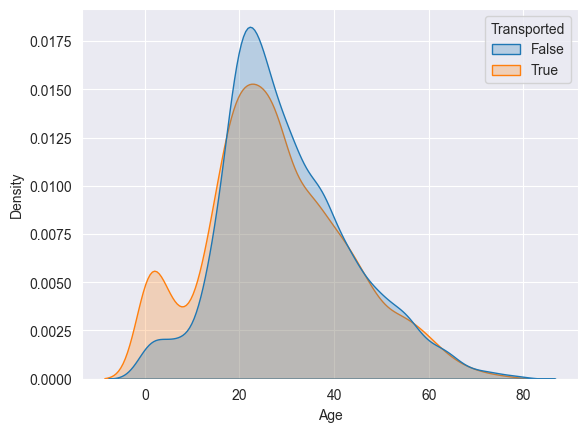

In [12]:
# Age/Transported Plot
sns.kdeplot(data=train, x="Age", hue="Transported", shade=True)
plt.show()

Die beiden Altersverteilungen sehen ziemlich ähnlich aus, abgesehen von dem Peak bei sehr jungen Altersgruppen für die transportierten Passagiere. 
Dies könnte darauf hindeuten, dass Kinder eine höhere Wahrscheinlichkeit hatten, transportiert zu werden.


Für die Ausgaben wird zunächst der Anteil untersucht, den die einzelnen Ausgabenkategorien ausmachen, und dann einen Blick auf die logarithmische Transformation von ihnen werfen, um einen besseren Überblick zu bekommen.

In [13]:
# Summiere die Ausgaben in den verschiedenen Kategorien
all_exp = train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum().sort_values(ascending=False)

# Benenne die berechnete Serie um
all_exp.name = "Anteil der einzelnen Ausgabenkategorien"

# Berechne den prozentualen Anteil
np.round(all_exp/all_exp.sum(), decimals=2)

FoodCourt       0.31
Spa             0.21
VRDeck          0.21
RoomService     0.15
ShoppingMall    0.12
Name: Anteil der einzelnen Ausgabenkategorien, dtype: float64

C:\Users\bbind\AppData\Local\Temp\ipykernel_1252\2795101947.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=log_train, x=feat, hue="Transported", common_norm=False, shade=True)
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtyp

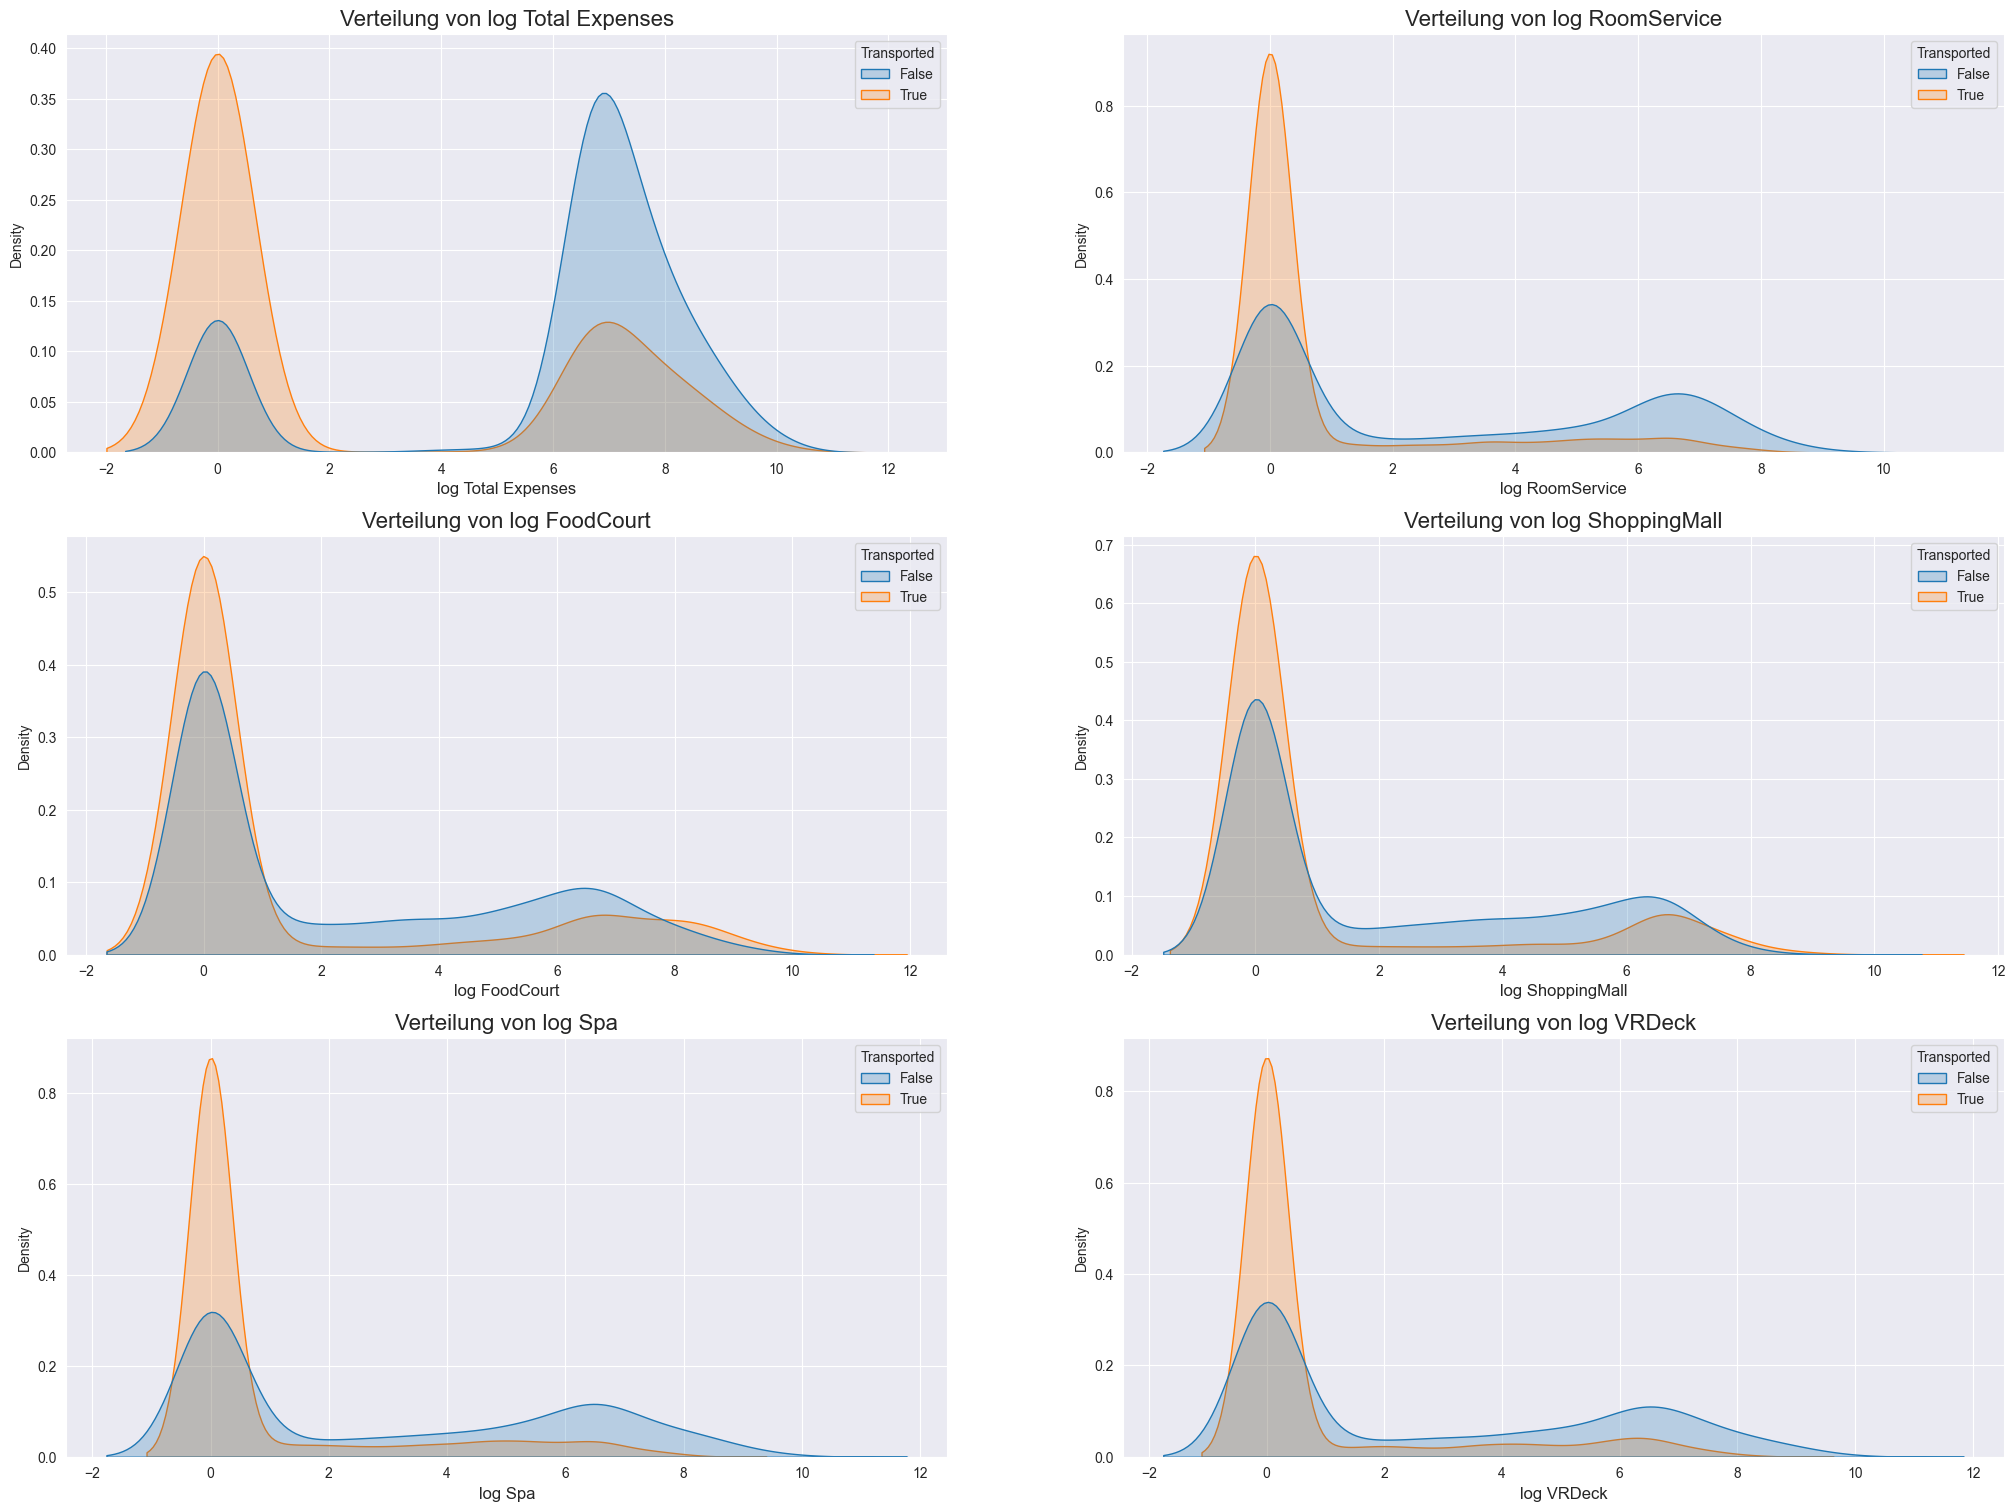

In [14]:
numeric_features = ["Total Expenses", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
log_train["Total Expenses"] = np.log(train.TotalExp+1)
plt.figure(figsize=(25,25))
for i, feat in enumerate(numeric_features):
    plt.subplot(4,2,i+1)
    sns.kdeplot(data=log_train, x=feat, hue="Transported", common_norm=False, shade=True)
    plt.xlabel("log "+feat, fontsize=12)
    plt.title("Verteilung von log "+feat, fontsize=16)

Man sieht, dass die Kategorie mit dem höchsten Prozentsatz der Gesamtausgaben der FoodCourt mit etwa 31% ist. Spa und VRDeck liegen sehr nah beieinander, ShoppingMall und RoomService haben den niedrigsten Prozentsatz.

Die Grafik für die Gesamtausgaben ist sehr aufschlussreich: Jede Verteilung ähnelt zwei separaten (fast) nicht verzerrten Normalverteilungen, mit einem Mittelwert von ~0 (da allen Ausgaben eins hinzugefügt wurde, 
um log(0) zu vermeiden, wäre der Mittelwert auf der Originalskala 0) und ~7 (exp(7)-1 auf der Originalskala, also etwa 1095).

Für die Passagiere, die transportiert wurden, befindet sich ein Großteil der Wahrscheinlichkeitsmasse um 0. Es scheint also vernünftig, dass Gäste, die weniger an Bord ausgegeben haben, eher transportiert wurden.
 Andererseits haben ein großer Teil der Passagiere, die nicht transportiert wurden, deutlich mehr Geld für die Kreuzfahrt ausgegeben.

Außerdem sieht man, dass die Verteilung der Ausgaben für transportierte vs. nicht transportierte Passagiere für die Ausgabenkategorien ShoppingMall und FoodCourt ähnlicher aussieht
 (hoher Peak um 0, kleiner Peak für höhere Ausgaben) und für die Kategorien Spa, VRDeck und RoomService unterschiedlicher aussieht (die alle eher Luxuskategorien zu sein scheinen).
  In letzteren Ausgabenkategorien sieht mN für nicht transportierte Passagiere eine höhere Wahrscheinlichkeitsmasse für höhere Ausgaben in diesen Bereichen.
  Dies könnte darauf hindeuten, dass privilegiertere Passagiere weniger wahrscheinlich transportiert wurden.

Die Ausgabenkategorien für Essen und Einkaufen scheinen weniger wichtig für die Vorhersage der Zielvariable zu sein, da beide Verteilungen für beide Kategorien sehr ähnlich aussehen. Das ergibt Sinn: Privilegierte Passagiere gaben ähnliche Beträge für Essen und Einkaufen aus (mit einer Tendenz zu hohen Ausgaben), gaben aber zusätzlich mehr für die luxuriösen Erlebnisse aus. Deshalb sind diese Luxusaufwendungen besser geeignet, um die Wahrscheinlichkeit von transportierten vs. nicht transportierten Passagieren vorherzusagen.


#### 2.2.2  Kategoriale Merkmale

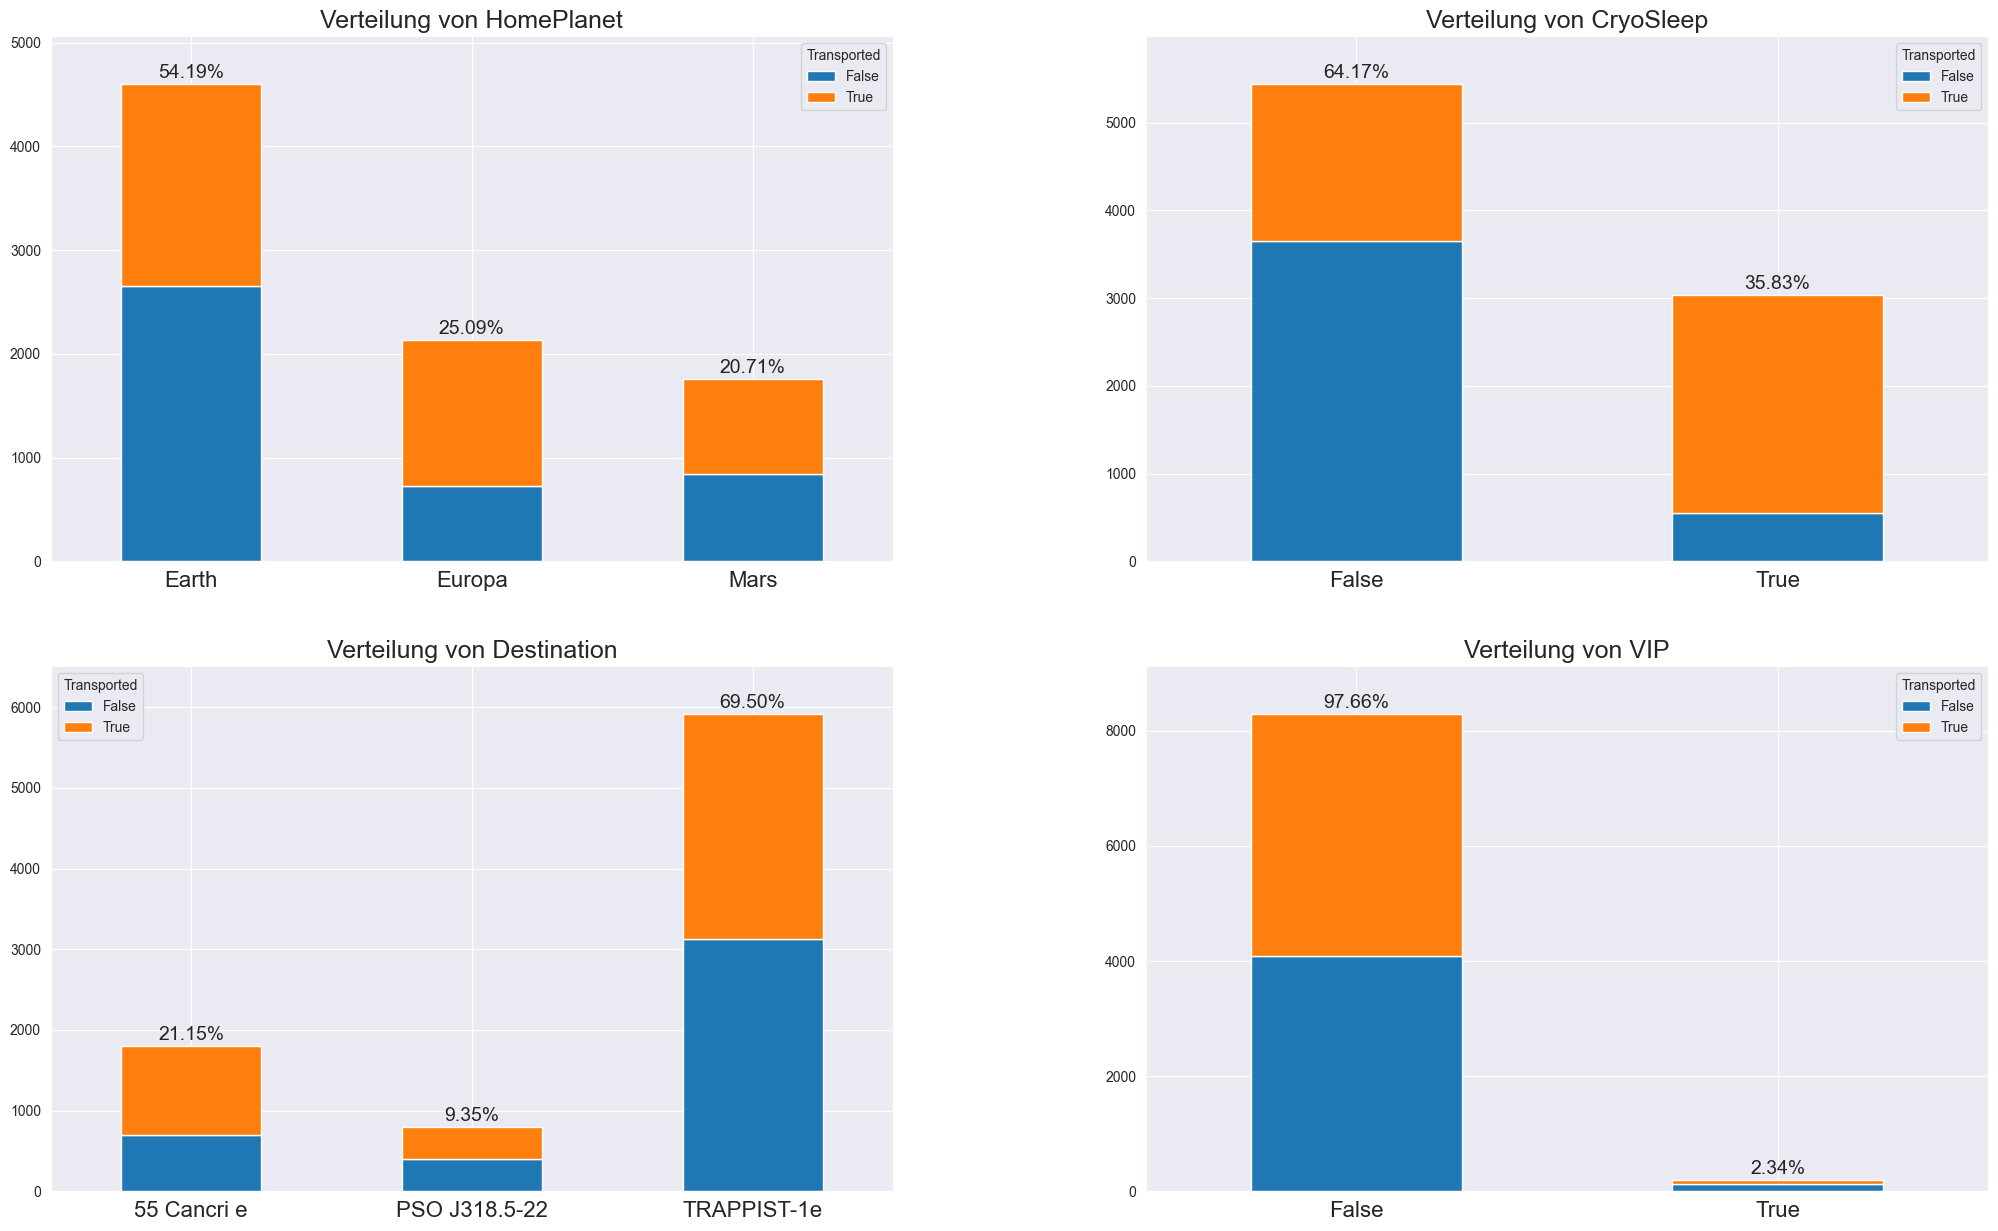

In [15]:
cat_feat = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
plt.figure(figsize=(25,15))

# Iteriere über die kategorialen Merkmale
for i, feat in enumerate(cat_feat):
    plt.subplot(2,2,i+1)
    
    # Gruppiere nach dem aktuellen kategorialen Merkmal und zähle die Transportierten und Nicht-Transportierten
    p1 = train.groupby(feat)["Transported"].value_counts().unstack().plot(kind="bar", stacked=True, rot=0, ax=plt.gca())
    
    # Berechne die Anzahl der Zeilen mit vorhandenen Werten für das Merkmal
    nrows = train.dropna(subset=feat).shape[0]
    
    # Funktion, um Prozentwerte auf den Balken anzuzeigen (angenommen, sie ist definiert)
    annotate_bar_perc(p1, nrows)
    
    # Einstellungen für die y-Achse (Obergrenze)
    y_upper = train[feat].value_counts().to_numpy().max()*1.1
    plt.ylim((0, y_upper))
    
    # Titel und Achsenbeschriftungen setzen
    plt.title("Verteilung von "+feat, fontsize=18)
    plt.xlabel("")
    plt.xticks(fontsize=16)

# Abstand zwischen den Unterdiagrammen einstellen
plt.subplots_adjust(wspace=0.3)

Für den "HomePlanet" (Heimatplaneten) sieht man, dass die meisten Passagiere von der Erde kamen und dass Gäste von Europa eher transportiert wurden.

Die Variable "CryoSleep" zeigt eine interessante Beziehung: Ein **sehr hoher Prozentsatz** der Passagiere, die sich entschieden haben, während der Kreuzfahrt im Kälteschlaf zu sein, wurden transportiert.

Außerdem kann man beobachten, dass der VIP-Status sehr selten war und nur ein kleiner Prozentsatz der Passagiere VIPs waren. 

### 2.3 Check für NaN-values

Nun zu den NaN-Werten. Was kommt in diesem Teil der Analyse, das ist:

   1. Wie viele NaN-Werte gibt es?
   2. Gibt es Zeilen mit einer sehr hohen Anzahl von NaN-Werten, die man löschen sollten?
   3. Wie sind sie verteilt? 
   4. Gibt es offensichtliche Muster? Gibt es eine Beziehung/Korrelation zwischen den Positionen der NaN-Werte? (Wenn der Wert einer Spalte fehlt, fehlt auch mit hoher Wahrscheinlichkeit ein anderer Wert.)

In [16]:
# Gib die Anzahl der Zeilen im DataFrame aus
print(f"Anzahl der Zeilen:                      {len(train)}")

# Gib die Anzahl der Zeilen mit mindestens einem NaN-Wert aus
print(f"Anzahl der Zeilen mit >= 1 NaN-Wert:    {train.isna().any(axis=1).sum()}")

# Berechne und gib den Prozentsatz der 'vollständigen' Zeilen aus
print(f"\nProzentsatz der 'vollständigen' Zeilen: {100-(train.isna().any(axis=1).sum()/len(train))*100:.2f}%")

Anzahl der Zeilen:                      8693
Anzahl der Zeilen mit >= 1 NaN-Wert:    2087

Prozentsatz der 'vollständigen' Zeilen: 75.99%


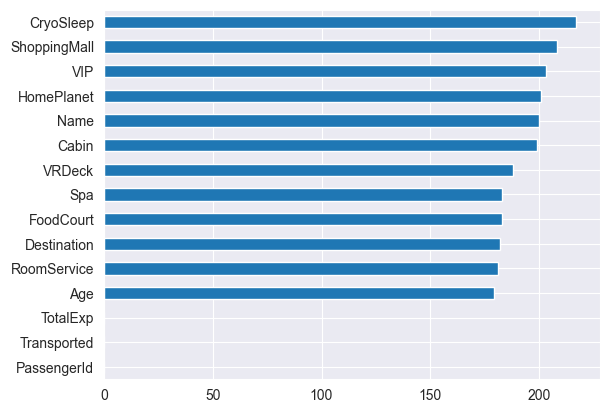

In [17]:
# Zeige die Anzahl der NaN-Werte in den einzelnen Spalten als horizontales Balkendiagramm an
train.isna().sum().sort_values().plot(kind="barh")

# Zeige das Diagramm an
plt.show()


Alle Spalten zeigen mehr oder weniger gleiche Mengen an NaN-Werten (~2%) - abgesehen von der Zielvariable und der Passagier-ID, die zu 100% mit Daten gefüllt sind.

Nun ein Blick auf die Positionen der NaN-Werte innerhalb der Spalten:

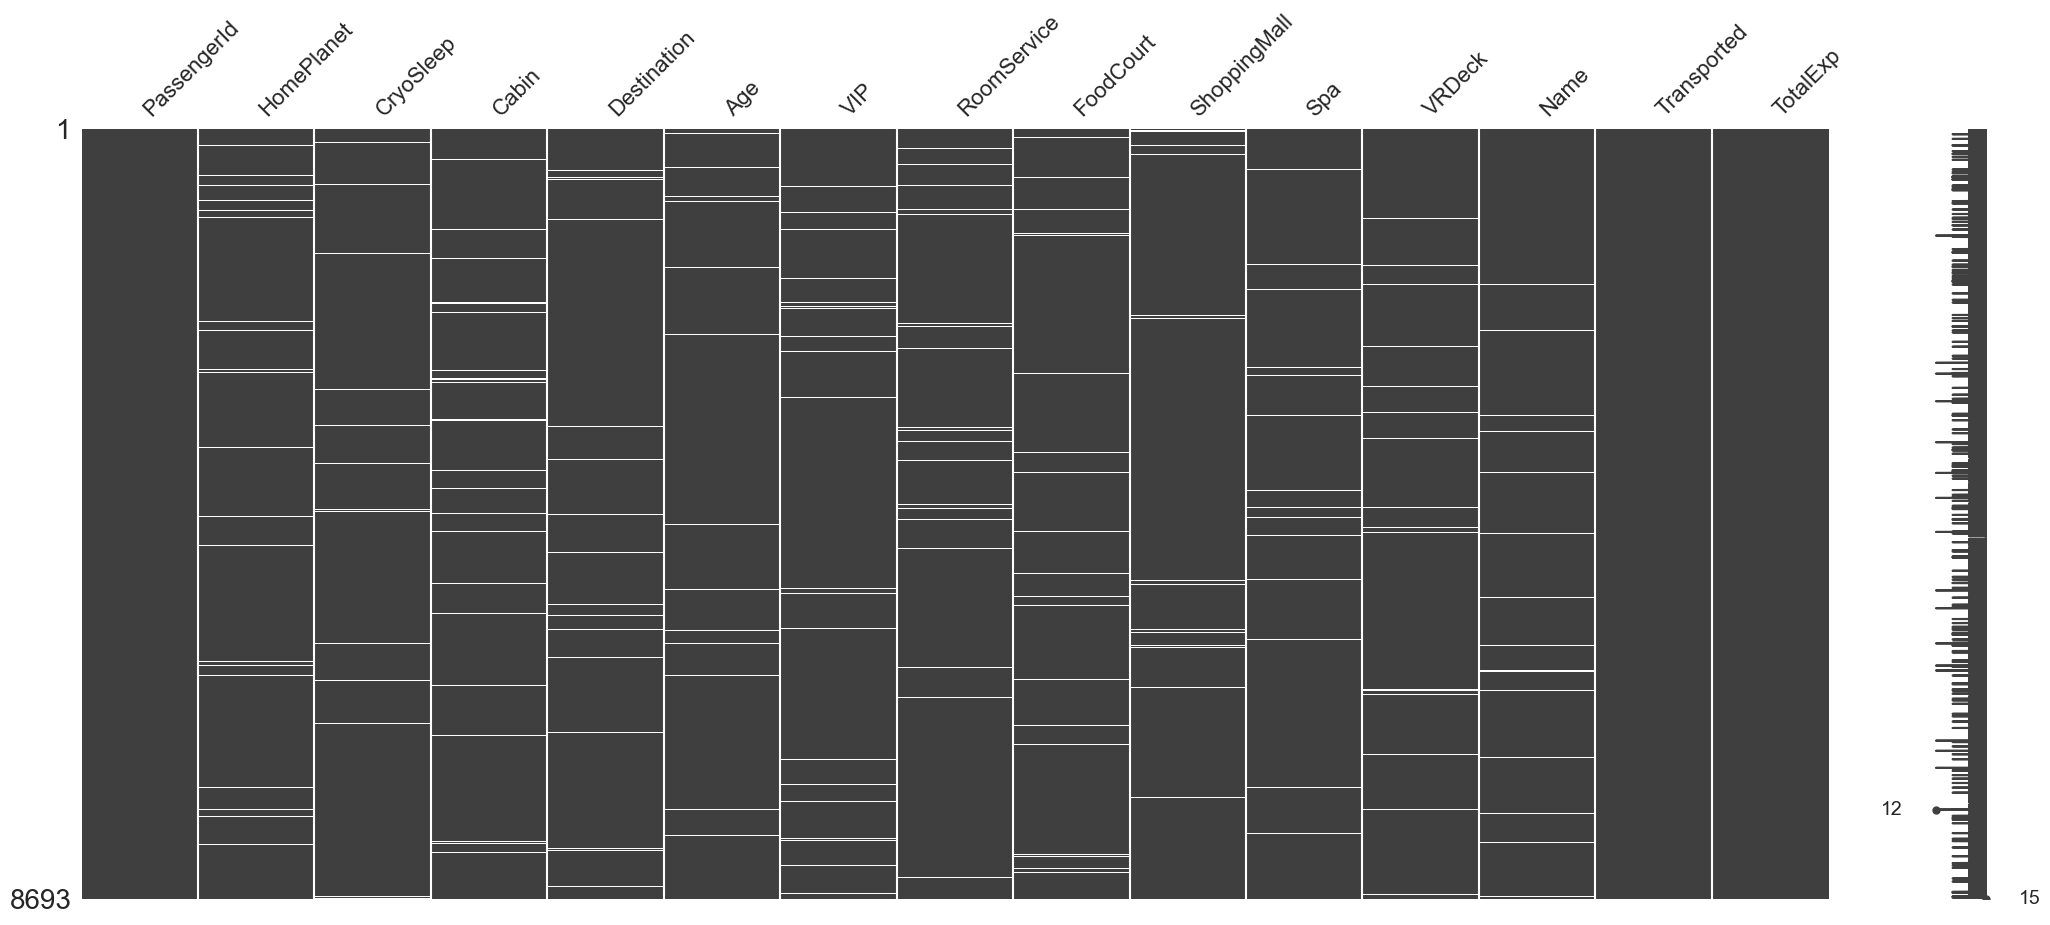

In [18]:
# Visualisiere fehlende Werte im Datensatz mit der Bibliothek missingno
msno.matrix(train)

# Zeige die Grafik an
plt.show()

In [19]:
# Ermittle das relative Auftreten der Anzahl von NaNs in den Zeilen.
(train.isna().sum(1)).value_counts(normalize=True)[1:]

1    0.214771
2    0.023352
3    0.001956
Name: proportion, dtype: float64

Man sieht, dass es immer mindestens 11 nicht-NaN-Werte aus den 14 Merkmalen gibt, was bedeutet, dass in einer Zeile maximal drei Werte fehlen. Dies ist nur selten der Fall.
- Die meisten Zeilen enthalten alle Daten, (\~76%)
- Viele Zeilen haben einen fehlenden Wert (\~21.5%), 
- Einige Zeilen haben zwei fehlende Werte (\~0.23%), 
- Sehr wenige Zeilen haben drei fehlende Werte (<0.02%).


Jetzt werden mögliche Korrelationen zwischen NaN-Werten untersucht. Um einen besseren Überblick zu bekommen, fasst man alle Ausgaben auf dem Deck zu einer neuen Spalte "Gesamtausgaben" zusammen.
 Außerdem entfernt man alle Zeilen, die keine NaN-Werte haben, da sie die Gleichheit von zwei verglichenen Spalten erhöhen würden (da 76% der Zeilen denselben Wert haben würden, nämlich 1,
 was auf einen vorhandenen Wert hinweist). Dieser Prozess wird zu höheren, leichter erkennbaren Korrelationen führen, als wenn man mit einer hohen Anzahl ähnlicher Werte verzerren würden. 


Hier sind die Interpretationen der (extremen) Korrelationen für NaN-Werte:

- -1: Wenn NaN in dieser Spalte, dann definitiv kein NaN in der anderen Spalte
-  0: Das Fehlen des Werts korreliert nicht mit dem Fehlen in der anderen Spalte
-  1: Wenn NaN in einer Spalte, dann definitiv NaN in der anderen Spalte ebenfalls

C:\Users\bbind\PycharmProjects\pythonProject\venv\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


ValueError: could not convert string to float: '--'

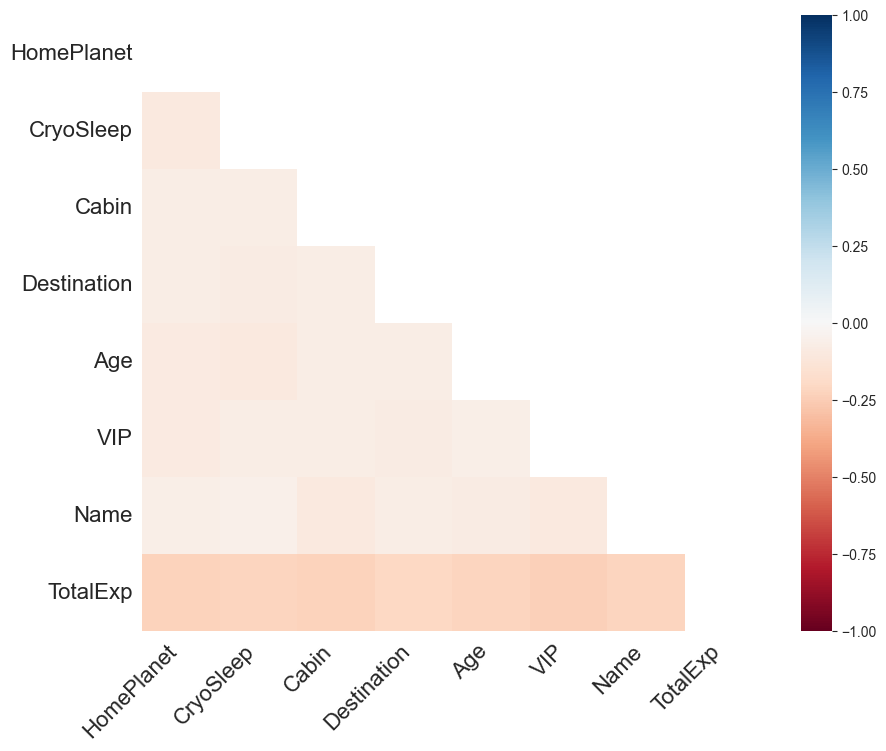

In [20]:
# NaNs in "TotalExpenses" anstelle von jedem einzelnen (höhere Wahrscheinlichkeit, Korrelationen zu sehen):
nan_corr = train.drop(["PassengerId", "Transported"], axis=1)
nan_corr["TotalExp"] = train.iloc[:, [7,8,9,10,11]].sum(axis=1, skipna=False)

# Lösche die einzelnen Ausgabenkategorien
nan_corr = nan_corr.drop(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1)

plt.figure(figsize=(10,8))
msno.heatmap(nan_corr[nan_corr.isna().any(axis=1)], ax=plt.gca())
plt.show()

**Ergebnisse der NaN-Analyse:**

- Die Spalten "PassengerId" und "Transported" (Zielvariable) enthalten keine fehlenden Werte.
- Im Allgemeinen haben die meisten Zeilen mindestens 11 Werte, was bedeutet, dass höchstens 3 Werte fehlen können. Daher ergibt das Löschen von Zeilen keinen Sinn.
- Es gibt keine Korrelation zwischen dem Auftreten von fehlenden Werten in verschiedenen Spalten. Alle Korrelationen sind <0,25 (es wurde also kein Muster im Hinblick auf die Verteilung der fehlenden Werte gefunden).

### 2.4 Erster Überblick über mögliche Korrelationen.

In [ ]:
plt.figure(figsize=(10,8))

# Erstelle eine Maske für die obere Dreiecksmatrix der Korrelationsmatrix
mask = np.triu(np.ones_like(train.corr()))

# Wähle eine Farbpalette für die Heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Erstelle die Heatmap
sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap, mask=mask, square=True, linewidths=.5)

# Zeige die Heatmap an
plt.show()

Aus diesem Korrelationsplot kan man bereits einige Informationen/Theorien ableiten, die man während der detaillierten Analyse der Merkmale untersuchen kann. Die folgenden Beziehungen scheinen interessant zu sein:

- CryoSleep und Transported haben die höchste (positive) Korrelation im Datensatz, was darauf hindeutet, dass Passagiere im Kälteschlaf wahrscheinlich transportiert wurden und umgekehrt.
- CryoSleep und alle Ausgabenkategorien scheinen leicht negativ korreliert zu sein, was darauf hindeutet, dass Passagiere im Kälteschlaf weniger ausgaben (was Sinn macht, da sie die ganze Zeit geschlafen haben).
- RoomService, Spa und der VRDeck sind leicht negativ mit der Zielvariable korreliert. Wir sollten untersuchen, ob Passagiere, die in diesen Bereichen mehr ausgaben,
  eher nicht transportiert wurden (vielleicht weil sie privilegierter waren? Hatten sie schönere Kabinen in einem anderen Teil des Schiffes?). 

Hinweis: Interessant ist, dass der VIP-Status nicht mit der Zielvariable korreliert ist - obwohl man denken würden, dass VIPs auch viel für RoomService/Spa/VRDeck ausgeben. Man sollte dies genauer untersuchen. 
<br>
<br>

<a id="Section2.1"></a>

## 3. Bivariate und Multivariate Analyse

In diesem Teil der Analyse gehts tiefer in die Beziehungen zwischen den Merkmalen, um die bereits erworbenen Theorien weiter zu untersuchen und neue zu erforschen.
Außerdem werden einige neue Merkmale aus z.B. der Passagier-ID extrahiert.

### 3.1 Feature Engineering - PassengerID 
> Eine eindeutige ID für jeden Passagier.
 > Jede ID hat die Form "gggg_pp", wobei "gggg" auf eine Gruppe hinweist, mit der der Passagier reist, und "pp" die Nummer des Passagiers innerhalb der Gruppe ist.
  > Personen in einer Gruppe sind oft Familienmitglieder, aber nicht immer.

In [ ]:
print(f"Der Trainingsdatensatz enthält {len(train)} Datensätze von Passagieren.")

In [ ]:
# Die maximale Anzahl der Vorkommen einer PassengerID im Trainingsdatensatz beträgt 1.
# Das bedeutet, dass jede PassengerID eindeutig ist.
train.PassengerId.value_counts().max()

In [ ]:
train.PassengerId.head(5)

**Entscheidung über die Vorverarbeitung der Variable**


Transformieren die Spalte, die die PassengerId im String-Format enthält, in drei neue Spalten um:

1. GroupID (int) - Eindeutige ID der Gruppe, zu der der Passagier gehört
2. GroupPos (int) - Position in der Gruppe, die dem Passagier zugewiesen ist
3. GroupSize (int) - Neues Merkmal, das jedem Passagier die Größe der Gruppe zuweist, zu der er gehört.

In [ ]:
def preprocess_PassengerId(data):
    """
    Preprocess PassengerID. Returns three columns:
        1. GroupID   - Eindeutige ID der Gruppe, zu der der Passagier gehört
        2. GroupPos  - Position in der Gruppe, die dem Passagier zugewiesen ist
        3. GroupSize - Neues Merkmal, das jedem Passagier die Größe der Gruppe zuweist, zu der er gehört
    """
    
    # Teile die PassengerId anhand des Unterstrichs auf und erstelle eine neue DataFrame 'new_ID'
    new_ID = data.PassengerId.str.split("_", expand=True)
    new_ID.columns = ["GroupID", "GroupPos"]
    
    # Konvertiere 'GroupPos' in Integer und entferne führende Nullen
    new_ID.GroupPos = new_ID.GroupPos.str.replace("0","").astype(int)
    
    # Erstelle ein Dictionary zur Zuordnung von ID zu Gruppengröße (ermittle die maximale 'GroupPos' in eindeutiger ID)
    group_size_dict = new_ID.groupby("GroupID").max().to_dict()["GroupPos"]
    
    # Weise jeder Zeile anhand des Dictionary die Gruppengröße zu
    new_ID["GroupSize"] = new_ID.apply(lambda row: group_size_dict[row["GroupID"]], axis=1)
    
    # Lösche führende Nullen aus 'GroupID' und konvertiere sie in Integer
    new_ID.GroupID = new_ID.GroupID.str.replace(pat=r"\b0+(?=\d)", repl="", regex=True).astype(int)
    
    return new_ID

# Füge neue Merkmale hinzu
train_old = train.copy()
train = pd.concat([train_old, preprocess_PassengerId(train_old)], axis=1)
train.head().iloc[:,-3:]

**Analysiere die Anzahl/Größe der Gruppen und die Position in der Gruppe**

In [ ]:
# Zähle die Anzahl der Gruppen für jede Größe
group_size_counts = train.groupby("GroupID")["GroupSize"].max().value_counts().reset_index()
group_size_counts.columns = ["GroupSize", "Counts"]

print(f"Gesamtanzahl der Gruppen: {group_size_counts.Counts.sum()}\n")
print(f"Prozent der allein Reisenden: {(train.GroupSize==1).mean()*100:.2f}%\n")
print(f"Übersicht über die Gruppengröße und die entsprechende Anzahl:\n")
print(group_size_counts)

In [ ]:
# Plotte, wer transportiert wurde, abhängig von der Gruppengröße und der Position in der Gruppe
plt.figure(figsize=(15,5))

# Erstes Diagramm: Gruppengröße vs. Transported
plt.subplot(1,2,1) 
train.groupby("GroupSize")["Transported"].value_counts().unstack().plot(kind="bar", rot=0, title="Transportiert vs. Gruppengröße", ax=plt.gca())

# Zweites Diagramm: Gruppenposition vs. Transported
plt.subplot(1,2,2)
train.groupby("GroupPos")["Transported"].value_counts().unstack().plot(kind="bar", rot=0, title="Transportiert vs. Gruppenposition", ax=plt.gca())

plt.show()

Nun kann man sehen, dass allein reisende Personen (über 55% aller Passagiere) etwas wahrscheinlicher nicht transportiert wurden. 
Umgekehrt sind Passagiere, die mit einer Gruppe auf dem Schiff sind (die meisten von ihnen wahrscheinlich als Familien), leicht wahrscheinlicher transportiert zu werden.

Aus dem zweiten Diagramm wird auch deutlich, dass die Position des Passagiers in der Gruppe keinen wirklichen Einfluss auf den Transport hat.
Sie zeigt eine ähnliche Beziehung zur Zielvariable wie die Gruppengröße. 
Es könnte jedoch interessant sein, das Alter zu betrachten, um zu sehen, ob das Alter der transportierten Person wichtig ist (sind Kinder wahrscheinlicher transportiert zu werden?).

In [ ]:
# Plot Alter vs. Gruppengröße/Position  
plt.figure(figsize=(15,5))

# Erstes Diagramm: Gruppengröße vs. Alter
plt.subplot(1,2,1) 
plt.title("Gruppengröße vs. Alter")
sns.boxplot(data=train, x="GroupSize", y="Age", ax=plt.gca(), palette="muted")

# Zweites Diagramm: Gruppenposition vs. Alter
plt.subplot(1,2,2)
plt.title("Gruppenposition vs. Alter")
sns.boxplot(data=train, x="GroupPos", y="Age", hue="Transported", ax=plt.gca(), palette="muted")

plt.show()


Man kann deutlich sehen, dass für Personen, die alleine reisen oder in einer Gruppe von zwei Personen (wahrscheinlich mit ihrem Partner/Freund in einer ähnlichen Altersgruppe),
die Wahrscheinlichkeit, transportiert zu werden, in verschiedenen Altersgruppen sehr ähnlich ist.
Außerdem wird deutlich, dass Gruppen von 1-2 Personen aus einer engeren Altersgruppe gebildet werden (75% rund um 20-40 Jahre), während größere Gruppen auch jüngere Passagiere einschließen.

Besonders interessant ist die Schlussfolgerung, dass in Gruppen von 3-4 Passagieren jüngere Passagiere im Vergleich zu älteren eher transportiert wurden.

**Funny note:** Jede Gruppengröße hat Babys, also Gäste, die als 0 Jahre alt angegeben sind. Es gibt sogar Babys, die alleine reisen!



Wie man sieht, scheint insbesondere die Gruppengröße einen gewissen Einfluss auf die Variable "Transported" zu haben.
Es ist jedoch zu beachten, dass beide neuen Spalten, "GroupPos" und "GroupSize", eine hohe Korrelation (0,75) aufweisen.
Es könnte daher sinnvoll sein, nur eine davon im endgültigen Modell zu verwenden (und "GroupPos" zu verwerfen).


**Man kann die Anzahl der Gruppen identifizieren, in denen alle Mitglieder transportiert oder nicht transportiert wurden, und sehen, ob es solche Gruppen gibt?**
<br>
Um diese Frage zu beantworten, sieht man sich alle Gruppen mit mindestens zwei Mitgliedern an und dann zählt man die Werte für transportiert/nicht transportiert in dieser Gruppe:

In [ ]:
# Erhalte die Anzahl von True/False für "Transported" für jede "GroupID"
groupID_transported = train[train.GroupSize>1].groupby("GroupID")["Transported"].value_counts().unstack(fill_value=0)

# Erhalte die Anzahl der Zeilen in diesem neuen DataFrame, in denen eines der Labels (True/False) null ist 
# (das bedeutet, dass alle entweder transportiert oder nicht transportiert wurden)
gleiches_Schicksal = (groupID_transported == 0).any(axis=1).sum()

print(f"Prozentsatz der Gruppenmitglieder in Gruppen>1, die das gleiche Schicksal teilen: {gleiches_Schicksal/len(groupID_transported)*100:.2f}%")

Das ist eine wichtige Erkenntnis! In über 43% aller Gruppen mit mindestens zwei Mitgliedern teilten alle Mitglieder der Gruppe das gleiche Schicksal!,
waren also entweder transportiert oder nicht. Eine mögliche Erklärung für diese Beobachtung könnte sein, dass sie (zum Beispiel als Familie) wahrscheinlich am selben Ort auf dem Schiff waren, als der Vorfall passierte.

**Kommen Personen in derselben Gruppe vom gleichen Planeten?**
<br>
Um diese Frage zu beantworten, sieht man sich alle Gruppen mit mindestens zwei Mitgliedern an und dann die Anzahl der eindeutigen Werte für ihren Heimatplaneten innerhalb der Gruppen und zählt sie:

In [ ]:
# Berechne die Anzahl der eindeutigen Heimatplaneten innerhalb jeder Gruppe
home_planet_groups = train[train.GroupSize>1].groupby("GroupID")["HomePlanet"].unique().apply(lambda x: len(x))

# Berechne den Prozentsatz der Gruppen, in denen alle Mitglieder vom gleichen Heimatplaneten stammen
same_planet = home_planet_groups.value_counts(normalize=True).iloc[0]

# Gebe das Ergebnis aus
print(f"In {same_planet*100:.2f}% aller Gruppen stammt jedes Gruppenmitglied vom gleichen Heimatplaneten.")

Diese Tatsache ist ebenfalls sehr aufschlussreich und man kann sie nutzen, um fehlende Werte im Heimatplaneten zu ergänzen.

**Kommen Personen in derselben Gruppe am gleichen Zielort an?**

In [ ]:
# Berechnung der Anzahl eindeutiger Zielorte innerhalb jeder Gruppe
zielorte_gruppen = train[train.GroupSize > 1].groupby("GroupID")["Destination"].unique().apply(lambda x: len(x))

# Anzeige der Häufigkeit dieser eindeutigen Zählungen
zielorte_gruppen.value_counts(normalize=True)

Hier sieht man ein etwas anders geartetes Bild:
Etwa 50% der Gruppen haben zwei unterschiedliche Zielorte, während bei 45% der Gruppen der Zielort für alle Mitglieder gleich ist.
Eine gute Strategie für die Ergänzung von fehlenden Heimatplaneten könnte sein, die Häufigkeit der Heimatplaneten in jeder Gruppe zu zählen.
Falls es nur einen gibt, wird dieser genommen.
Andernfalls wird der mit der höchsten Häufigkeit ausgewählt.
Im Fall von zwei oder mehr gleich häufigen Heimatplaneten wird einer von ihnen zufällig ausgewählt.

In [ ]:
# Erstelle eine Maske, die Zeilen für Passagiere in Gruppen > 1 zurückgibt, in denen mindestens einer VIP ist
mask_group_vip = train.groupby("GroupID")["VIP"].transform(lambda x: (len(x)>1)&(x.sum()>=1))

# Zähle die Anzahl der VIPs in jeder Gruppe
train[mask_group_vip].groupby("GroupID")["VIP"].sum().value_counts()

Aus dem Ergebnis wird deutlich, dass in fast allen Gruppen, die mindestens einen VIP haben, nur ein einziger VIP vorhanden ist.
Daher können wir im Hinblick auf die Datenreinigung alle NaN-Werte sicherheitshalber mit "False" auffüllen.
Dies ist insgesamt die wahrscheinlichste Option. 
Selbst wenn bereits ein VIP in der Gruppe ist, haben wir festgestellt, dass das nicht bedeutet, dass auch die anderen Mitglieder der Gruppe VIP-Status haben. 

### 3.2 CryoSleep vs. Expenses (Kosten/Ausgaben)

Jetzt schaut man, was Passagiere für CryoSleep im Vergleich zu denen, die nicht in CryoSleep waren, ausgegeben haben,
denn es würde Sinn machen, dass diejenigen in CryoSleep weniger Geld ausgegeben haben als andere, da sie die ganze Zeit geschlafen haben.

In [ ]:
# Dieses Violinplot visualisiert die Verteilung der Gesamtausgaben für Passagiere, die sich im Kryoschlaf befanden im Vergleich zu denen, die es nicht taten.
# Der Parameter "hue" differenziert die Datenpunkte basierend darauf, ob die Passagiere transportiert wurden oder nicht.
sns.violinplot(data=log_train.dropna(subset="CryoSleep"), x="CryoSleep", y="Total Expenses", hue="Transported")

# Den Plot anzeigen
plt.show()

In [ ]:
# Beweis, dass die Summe aller Ausgaben von Passagieren im Kryo-Schlaf 0 beträgt
train[train["CryoSleep"]==True]["TotalExp"].sum()

Man kann aus dem Diagramm erkennen, dass Passagiere im Kryo-Schlaf anscheinend nichts an Bord ausgeben.
Der obige Code-Befehl beweist diese Annahme, dass die Summe aller Ausgaben von Passagieren im Kryo-Schlaf tatsächlich 0 ist.
Wie bereits erwähnt, ergibt dies total Sinn, wenn man bedenkt, dass sie sich in einem Zustand der ausgesetzten Animation befinden, in dem sie höchstwahrscheinlich kein Verlangen nach Essen haben
(und natürlich ihre Kabine nichtverlassen können, um einzukaufen usw.).


Das ist eine sehr wichtige Erkenntnis aus zwei Perspektiven:

1. Man weis jetzt, dass Personen im Kryo-Schlaf kein Geld ausgeben. 
   Dies erklärt nicht nur die hohe Anzahl von Nullausgaben, die wir in den zuvor gezeigten Diagrammen gesehen haben (da mehr als 35% der Passagiere im Kryo-Schlaf sind), 
   sondern hilft auch, mehr Einblick in die Ausgabenmuster zu bekommen, indem man diejenigen Passagiere eliminieren, die sowieso nichts kaufen können (zum Beispiel kann man jetzt sehen, 
   ob es immer noch Passagiere gibt, die überhaupt nichts kaufen, ...).
   
2. Es kann helfen, Werte zu imputieren (wenn Kryo-Schlaf -> Ausgaben = 0, wenn Ausgaben = 0 -> (wahrscheinlich) Kryo-Schlaf), 
   viel besser im Vergleich zur Imputation fehlender Ausgaben mit dem Mittelwert, selbst wenn der Passagier schläft!

Nun die Strategien zur Imputation von NaN-Werte, die man aus der beobachteten Beziehung ableiten kann:

#### NaN-Imputation für CryoSleep and Expenses

Man kann bereits zwei Imputationsstrategien identifizieren, die ohne jeden Zweifel angewendet werden können und keine zusätzlichen Verzerrungen in die Daten einführen (sondern wertvolle Informationen hinzufügen):

1. CryoSleep = True, TotalExp = NaN:
        Imputation: TotalExp = 0 (Sicherheit: 100%)

2. CryoSleep = NaN, TotalExp > 0:
        Imputation: CryoSleep = False (Sicherheit: 100%)
         
Für die anderen Fälle muss man die Daten zunächst analysieren, um geeignete Imputationen zu finden. Man beginnt mit dem folgenden Fall:

3. CryoSleep = NaN, TotalExp = 0:
   Hier mag es auf den ersten Blick naheliegend erscheinen, einfach mit True zu imputieren, da Personen im Kryo-Schlaf nichts an Bord ausgeben.
   Aber das gilt nur für eine Richtung, wir weiss noch nicht, ob es vielleicht viele andere Passagiere gibt, die nicht im Kryo-Schlaf sind, aber trotzdem kein Geld ausgeben.

Das wird jetzt genauer untersucht.

Aber zuerst schaut man nach, ob diese detaillierte Analyse überhaupt lohnenswert ist, also wie viele NaN-Werte man mit einer guten Strategie lösen könnten:


In [ ]:
# Zuerst müssen wir sicherstellen, dass in der Spalte TotalExp korrekt angegeben ist, ob eine Ausgabenkategorie NaN ist.
cryo_expenses = train[["CryoSleep", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].copy()
cryo_expenses["TotalExpNan"] = cryo_expenses[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(1, skipna=False)

# Boolesche Maske für >= 1 NaN (entweder CryoSleep und/oder TotalExpNan)
mask_nan_geq_1 = cryo_expenses.isna().any(axis=1)
cryo_expenses_nan = cryo_expenses[mask_nan_geq_1]
print(f"Zeilen mit >= 1 NaN (CryoSleep und/oder TotalExp): {mask_nan_geq_1.sum()}")

**Note:** Diese Zahl unterstreicht die Tatsache, dass diese sehr detaillierte Analyse der verschiedenen Fälle sich als äußerst wertvoll für die Leistung der trainierten Modelle erweisen könnte!
          Am Anfang wurde festgestellt, dass von den 8693 Zeilen im Trainingsdatensatz 2087 mindestens einen NaN-Wert enthalten. 
          Die verschiedenen Fälle, die man hier untersucht, in Bezug auf die NaN-Werte von CryoSleep und allen Ausgabenkategorien, machen über 50% aller dieser NaN-enthaltenden Zeilen aus. 
          Wenn man also für alle Fälle gute/sichere Strategien findt, steigert man die Sauberkeit und somit den Informationsgehalt des Datensatzes immens!

Den wahrscheinlichsten Wert für CryoSleep finden, wenn die Gesamtausgaben 0 sind:

In [ ]:
# Anzahl aller Fälle, in denen TotalExp=0 ist
print(f"Alle Fälle mit TotalExp=0: {cryo_expenses[(cryo_expenses.TotalExpNan==0)].dropna(subset=['CryoSleep']).shape[0]}\n")

# Anzahl aller Fälle, in denen CryoSleep=True und TotalExp=0 ist
print(f"Alle Fälle mit CryoSleep=True & TotalExp=0: {cryo_expenses[cryo_expenses.CryoSleep&(cryo_expenses.TotalExpNan==0)].shape[0]}")

# Anzahl aller Fälle, in denen CryoSleep=False und TotalExp=0 ist
print(f"Alle Fälle mit CryoSleep=False & TotalExp=0: {cryo_expenses[~cryo_expenses.CryoSleep&(cryo_expenses.TotalExpNan==0)].shape[0]}")

Aus rein wahrscheinlichkeitstheoretischer Sicht wäre die wahrscheinlichere Imputation für Fall 3 wohl CryoSleep=True. 
Dennoch werden wir uns die 470 Fälle genauer ansehen, in denen trotz wachen Zustands keine Ausgaben getätigt wurden. 

Besonders die Altersverteilung ist interessant:

In [ ]:
# Füge die Altersspalte hinzu 
cryo_expenses["Age"] = train.Age.copy()

In [ ]:
# Erstelle eine Abbildung mit zwei Unterdiagrammen
plt.figure(figsize=(13, 4))

# Unterdiagramm 1
plt.subplot(1,2,1)
# Erstelle ein Histogramm der Altersverteilung für den Fall, dass CryoSleep=False und TotalExp=0
bins1, ages1, _ = plt.hist(cryo_expenses[~cryo_expenses.CryoSleep & (cryo_expenses.TotalExpNan==0)].Age, bins=70)
# Zeichne eine vertikale Linie bei einem bestimmten Alterswert
plt.axvline(12, ymax=0.95, color="C3", ls="--", lw=1, label="Altersgrenze: 12")
# Füge eine Legende hinzu
plt.legend()
plt.title("CryoSleep=False | TotalExp=0")
plt.xlabel("Alter")

# Unterdiagramm 2
plt.subplot(1,2,2)
# Erstelle ein Histogramm der Altersverteilung für den Fall, dass CryoSleep=True und TotalExp=0
bins2, ages2, _ = plt.hist(cryo_expenses[cryo_expenses.CryoSleep & (cryo_expenses.TotalExpNan==0)].Age, bins=70)
# Zeichne eine vertikale Linie bei einem bestimmten Alterswert
plt.axvline(12, ymax=0.95, color="C3", ls="--", lw=1, label="Altersgrenze: 12")
# Füge eine Legende hinzu
plt.legend()
plt.title("CryoSleep=True | TotalExp=0")
plt.xlabel("Alter")

# Setze den Gesamttitel
plt.suptitle("Altersverteilung beider Imputationsfälle")

# Stelle sicher, dass die Diagramme nicht überlappen
plt.tight_layout()

# Zeige die Abbildung an
plt.show()

In [ ]:
# Mit dem folgenden DataFrame können wir den Schwellenwert finden
pd.DataFrame({"BinHeight":bins1, "Age":ages1[1:]} ).head(30)

In [ ]:
# Get Cutoff-quantiles
q1 = (cryo_expenses[~cryo_expenses.CryoSleep & (cryo_expenses.TotalExpNan==0)].Age <= 12).mean() 
q2 = (cryo_expenses[cryo_expenses.CryoSleep & (cryo_expenses.TotalExpNan==0)].Age > 12).mean()

print(f"CryoSleep=False | TotalExp=0:  {q1*100:.2f}% der Passagiere sind <= 12 Jahre alt")
print(f"CryoSleep=True  | TotalExp=0:  {q2*100:.2f}% der Passagiere sind  > 12 Jahre alt")

Aus beiden Diagrammen wird deutlich, dass die Theorie sich als richtig herausgestellt hat. 
Wenn man sich alle Fälle ansieht, in denen die Gesamtausgaben null sind, und die Altersverteilung für Passagiere im Kryoschlaf und solche, die nicht im Kryoschlaf sind, vergleicht, 
sieht man, dass letztere eine sehr schmale Verteilung mit einer starken Tendenz zu jüngeren Altersgruppen zeigt. 
Über 78% der Passagiere, die nicht im Kryoschlaf sind und die immer noch nichts an Bord ausgeben, sind 12 Jahre oder jünger. 
Die Theorie, dass kleine Kinder kein eigenes Geld haben, sondern von ihren Eltern bezahlt werden, scheint also zuzutreffen.

Das zweite Diagramm für Personen im Kryoschlaf zeigt eine breitere Verteilung und tendiert zu höheren Altersgruppen. 
Mehr als 84% der Passagiere in dieser Gruppe sind älter als 12 Jahre. Es ähnelt ein wenig einer Normalverteilung, die um etwa 23 Jahre zentriert ist.

Beide Diagramme zeigen einen Schnitt bei etwa dem gleichen Alter: 
Im ersten Fall sinken die Beobachtungswahrscheinlichkeiten signifikant, während sie im zweiten Fall sofort ansteigen. 
Deshalb scheint 12 ein guter Altersgrenzwert zu sein, um zwischen beiden Verteilungen zu unterscheiden.

Zusammenfassend hat man festgestellt, dass es anstatt anzunehmen, dass jede Person mit 0 Ausgaben im Kryoschlaf ist, besser ist, die fehlenden Kryoschlafwerte zu imputieren, 
wenn man gleichzeitig das Alter des Passagiers zu betrachten: 

Wenn der Passagier jünger als 13 Jahre ist, nimmt man an, dass er oder sie nicht im Kryoschlaf ist. 
Für ältere Passagiere hat gezeigt, dass es wahrscheinlicher ist, dass sie im Kryoschlaf sind, daher in diesem Fall True imputieren. 
Natürlich wird diese Methode einige Fehler produzieren, sollte aber für eine qualitativ hochwertige Imputation ausreichend sein.

<br>
Ein Entscheidungsbaum mit nur einem Schnitt basierend auf dem Merkmal Alter vorschlagen würde 
(basierend auf der Minimierung der gewichteten Entropie zur Erhöhung des Reinheitsgrades der beiden Blattknoten):

In [ ]:
# Erstelle einen Entscheidungsbaum-Klassifikator mit einer maximalen Tiefe von 1 und verwende die Entropie als Kriterium für die Unreinheit
decTree = tree.DecisionTreeClassifier(max_depth=1, criterion="entropy")

# Wähle relevante Daten für das Experiment aus (Alter und CryoSleep) und filtere Zeilen mit fehlenden Werten heraus
age_cryo_zero_exp = cryo_expenses[cryo_expenses.TotalExpNan==0].dropna(subset=["Age", "CryoSleep"])[["Age", "CryoSleep"]]

# Trainiere den Entscheidungsbaum mit dem Alter als Eingabeattribut und CryoSleep als Zielvariable
decTree = decTree.fit(X=age_cryo_zero_exp.Age.to_numpy().reshape(-1, 1), y=age_cryo_zero_exp.CryoSleep.map(lambda x: 1 if x else 0))

# Visualisiere den resultierenden Entscheidungsbaum
tree.plot_tree(decTree, filled=True)
plt.show()

In [ ]:
# Erstelle eine binäre Zielvariable für die Gesamtausgaben
train["TotalExpBinary"] = (train["TotalExp"] > 0).astype(int)

# Trainiere einen Entscheidungsbaum mit nur einem Split basierend auf dem Alter
baum = DecisionTreeClassifier(max_depth=1, random_state=42)
baum.fit(train[["Age"]], train["TotalExpBinary"])

# Erstelle das Streudiagramm von Alter vs. Gesamtausgaben
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train, x="Age", y="TotalExp", hue="TotalExpBinary", palette="viridis")

# Zeichne die Entscheidungsgrenze
x_values = np.linspace(train["Age"].min(), train["Age"].max(), 100)
y_values = [0] * len(x_values)  # Wir sind nur an der horizontalen Linie interessiert
plt.plot(x_values, y_values, color="red", linestyle="--", linewidth=2, label="Entscheidungsgrenze")

plt.title("Von DecisionTree vorgeschlagene Entscheidungsgrenze")
plt.legend()
plt.show()

4. CryoSleep = False, TotalExp = NaN: 
   Dieser Fall ist nicht so leicht lösbar wie die anderen Fälle.
   Im Moment gibts nicht genügend Informationen, um eine zufriedenstellende Imputationsstrategie zu finden. 

Aber im späteren Teilen der Analyse, kann der folgende Prozess verwendet werden:

- Passagiere, die jünger oder gleich 12 Jahre alt sind, werden niemals Geld ausgeben. 
  Hier kann man daher sicher von Ausgaben in Höhe von 0 ausgehen.
  
- Man wird feststellen, dass neben den Passagieren im Kryoschlaf, die während der Kreuzfahrt kein Geld ausgeben, und den Kindern im Alter von 12 Jahren oder jünger, 
  noch eine nicht unerhebliche Anzahl von Personen gibt, die nichts ausgeben (die offensichtlichste Erklärung: Andere Gruppen-/Familienmitglieder zahlen für sie). 
 
- Wenn alle anderen Ausgabenkategorien 0 sind, ist es wahrscheinlich, dass auch die NaN-Kategorie 0 ist.

- Ausgaben stehen in engem Zusammenhang mit der Gruppe, mit der man reist. 
  Wenn die Gruppengröße > 1 ist, können wir den Mittelwert/Median der Ausgabenkategorie nehmen, die für die Gruppe fehlt, und diesen Wert zur Imputation verwenden.
  
- In allen anderen Fällen, also für allein reisende Passagiere, werden wir feststellen, dass die Ausgaben auch mit dem Deck verbunden sind, auf dem sich die Kabine des Passagiers befindet. 
  Für diese Fälle macht es also Sinn, den Median des Decks als grobe Näherung zu verwenden (nicht den Mittelwert, da er empfindlicher gegenüber Ausreißern ist, die insbesondere bei den Ausgaben vorhanden sind).

In [ ]:
case_4 = cryo_expenses[(~cryo_expenses.CryoSleep&(cryo_expenses.TotalExpNan.isna()))]

# Wie viele Fälle gibt es?
print(f"Fall 4 macht insgesamt {case_4.shape[0]} NaN-Fälle aus.")

<br>

### 3.3 Feature Engineering - Cabin
> Die Kabinennummer, in der der Passagier untergebracht ist. Sie hat das Format Deck/Nummer/Seite, wobei die Seite entweder P für Backbord oder S für Steuerbord sein kann.

<br> 

**Entscheidung über die Vorverarbeitung der Variable.**

Wandel die Spalte, die die Kabine im String-Format enthält, in drei neue Spalten um:
1. Deck (str)    - Buchstabe, der auf das Deck verweist, auf dem sich die Kabine befindet
2. Number (str)  - Kabinennummer
3. Side (str)    - Seite des Schiffes, entweder P (Backbord) oder S (Steuerbord)

In [ ]:
def preprocess_Cabin(data):
    """
    Vorverarbeitung der Kabine. Gibt drei Spalten zurück:
        1. Deck    - Buchstabe, der auf das Deck verweist, auf dem sich die Kabine befindet
        2. Number  - Kabinennummer
        3. Side    - Seite des Schiffs, entweder P für Backbord oder S für Steuerbord
    """
    
    # Teile die Kabine in drei neue Spalten auf
    new_cols = data.Cabin.str.split("/", expand=True)
    new_cols.columns = ["Deck", "CabinNum", "Side"]
    return new_cols

# Kopiere den ursprünglichen Datensatz und füge die vorverarbeiteten Kabineninformationen hinzu
train_old = train.copy()
train = pd.concat([train_old, preprocess_Cabin(train_old)], axis=1).drop("Cabin", axis=1)


**Analyse der neuen Features und ihrer Beziehungen**

Zuerst einen allgemeinen Überblick über die Deck- und die Side-Features bekommen:

In [ ]:
# Die Zeile gruppiert den DataFrame "train" nach der Spalte "Side" und zählt die Werte der Spalte "Transported" in jeder Gruppe.
# Das Ergebnis wird als Dataframe mit den Seiten als Index und den Transportierten als Spalten angeordnet.
p1 = train.groupby("Side")["Transported"].value_counts().unstack().plot(kind="bar", stacked=True, rot=0)

# Setzt die y-Achse auf einen Bereich von 0 bis 5000.
plt.ylim((0, 5000))

# Setzt den Titel des Diagramms auf "Seite vs. Transportiert".
plt.title("Seite vs. Transportiert")

# Zeigt das Diagramm an.
plt.show()

In [ ]:
# Legt die Größe des Diagramms auf 10x5 Zoll fest.
plt.figure(figsize=(10,5))

# Gruppiert den DataFrame "train" nach der Spalte "Deck" und zählt die Werte der Spalte "Transported" in jeder Gruppe.
# Das Ergebnis wird als Dataframe mit den Decks als Index und den Transportierten als Spalten angeordnet.
p1 = train.groupby("Deck")["Transported"].value_counts().unstack().plot(kind="bar", rot=0, title="Deck vs. Transported", ax=plt.gca(), stacked=True)

# Setzt die y-Achse auf einen Bereich von 0 bis 3100.
plt.ylim((0,3100))

# Zeigt das Diagramm an.
plt.show()


Das Deck der Kabinen scheint einen Einfluss auf die Zielvariable zu haben, da zum Beispiel ein höheres Verhältnis von Passagieren auf Deck B/C transportiert wurden, 
während das Verhältnis für transportierte Passagiere auf Deck D/E kleiner ist. 
Die beiden größten Kategorien F/G, die zusammen über 60% aller Passagiere ausmachen, zeigen eine eher gleichmäßige Verteilung zwischen transportierten und nicht-transportierten Passagieren. 
Kategorie T macht nur 0,1% aller Fälle aus (nur 5 Datenpunkte), weshalb es sinnvoll sein könnte, diese Beispiele möglicherweise zu verwerfen (vielleicht nur Rauschen).

Außerdem kann man sehen, dass die Seite des Schiffs, auf der sich die Passagierkabine befindet, keinen Einfluss auf die Zielvariable hat. 
Dies gilt nicht nur für die Zielvariable, sondern auch für alle anderen Variablen. 
Zum Beispiel kann man hier die Altersverteilung je nach Seite der Kabine sehen:

In [ ]:
# Verwendet die seaborn-Bibliothek, um ein Kernel Density Estimation (KDE) Plot zu erstellen.
# Das KDE-Plot visualisiert die Verteilung der Alterswerte abhängig von der Kabinenseite.
sns.kdeplot(data=train, x="Age", hue="Side")

# Setzt den Titel des Plots auf "Altersverteilung abhängig von der Kabinenseite".
plt.title("Altersverteilung abhängig von der Kabinenseite")

# Zeigt den erstellten Plot an.
plt.show()

Beide KDE-Plots sehen fast identisch aus. Wie beschrieben, trifft diese Beziehung auf alle anderen Variablen zu.

Im Folgenden liegt der Fokusauf dem Deck, auf dem sich die Gästekabine befindet, da hier einige interessante Beziehungen zu sehen sind. 
Zunächst einen Blick auf den Anteil der verschiedenen Werte der kategorialen Variablen Heimatplanet, Zielort, Kryoschlaf und VIP-Status in jeder der Deckkategorien. 
Kategorie T wird ausgeschlossen, da sie nur 0,1% aller Kabinen ausmacht.

In [ ]:
# Setzt die Größe des gesamten Plots auf 25x15 Zoll.
plt.figure(figsize=(25,15))

# Liste der Features, die analysiert werden sollen.
feats = ["HomePlanet", "Destination", "CryoSleep", "VIP"]

# Iteriert über die Features.
for i, feat in enumerate(feats):
    # Erstellt ein Subplot im Raster 2x2 an Position i+1.
    plt.subplot(2,2,i+1)
    
    # Setzt den Titel des Subplots auf das aktuelle Feature und den Text "Verteilung in Deck-Kategorien".
    plt.title(feat+" Verteilung in Deck-Kategorien", fontsize=18)
    
    # Gruppiert den DataFrame "train" nach der Spalte "Deck" und zählt die Werte der Spalte "feat" in jeder Gruppe.
    # Das Ergebnis wird als Dataframe mit den Decks als Index und den Werten von "feat" als Spalten angeordnet.
    # Leere Felder werden mit 0 gefüllt, die Kategorie "T" wird entfernt.
    train.groupby("Deck")[feat] \
         .value_counts() \
         .unstack() \
         .fillna(0) \
         .drop("T") \
         .plot(kind="bar", stacked=True, rot=0, ax=plt.gca())
    
    # Fügt die Legende hinzu und passt die Schriftgröße an.
    plt.legend(prop={"size": 15})
    
    # Passt die Größe der x-Achsenbeschriftungen an.
    plt.xticks(fontsize=16)
    
    # Entfernt die x-Achsenbeschriftung.
    plt.xlabel("")

**HomePlanet**
<br>
Für den "HomePlanet"(Heimatplaneten) gibts interessante Informationen aus dem Plot: 
Passagiere auf den Decks A, B und C stammen ausschließlich vom Planeten Europa. 
Die Decks D, E und F sind stärker gemischt zwischen den drei Heimatplaneten. 
Deck G wird ebenfalls ausschließlich von Passagieren von einem Planeten, der Erde, bewohnt.

Diese Informationen können verwendet werden, um fast die Hälfte der NaN-Fälle in der Spalte Heimatplanet sicher zu imputieren. 
Für die verbleibenden NaNs muss man später eine andere Strategie wählen (z.B. nächster Nachbar/Entscheidungsbaum/Sampling mit Gewichten entsprechend den Anteilen aus dem obigen Plot/...).

In [ ]:
print(f"Alle NaNs im Heimatplanet   : {train.HomePlanet.isna().sum()}")
print(f"Sicher auflösbar (A/B/C/G)  : {train[train.HomePlanet.isna() & (train.Deck.isin(['A', 'B', 'C', 'G']))].shape[0]}")

In [ ]:
# Entscheidungsbaum erstellen, der dieselben Beziehungen/Imputationsstrategien wie oben beschrieben findet
X = train.copy()
X = X.dropna()
y = X.HomePlanet
X = pd.get_dummies(X[["CryoSleep", "Destination", "Age", "VIP", 
                      "RoomService", "FoodCourt", "ShoppingMall", 
                      "Spa", "VRDeck", "Transported", "GroupID", 
                      "GroupPos", "GroupSize", "Deck", "Side"]], drop_first=True)

dt = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=100).fit(X, y)

# Den Baum visualisieren
plt.figure(figsize=(20,20))
tree.plot_tree(dt, feature_names=dt.feature_names_in_, class_names=dt.classes_, filled=True)
plt.show()

**Destination**
<br>
Für das Ziel (Destination) gewinnt man im Gegensatz zum Heimatplaneten nicht viele zusätzliche Informationen. 
Man kann zum Beispiel sehen, dass Passagiere von A/B alle vom Planeten Europa starten und entweder zu TRAPPIST-1e oder 55 Cancri e reisen. 
Aber im Allgemeinen sieht es ziemlich zufällig aus, mit nur einigen kleineren Unterschieden im Anteil jedes jeweiligen Ziels in den Deckgruppen.

**CryoSleep**
<br>
Bezüglich des Kryoschlafs kann man sehen, dass besonders in Gruppe B und G ein hoher Anteil der Passagiere schläft (~50% im Vergleich zu ~35% im gesamten Datensatz).

**VIP**
<br>
Im Falle des VIP-Status kann man eine nützliche Beobachtung für unsere Imputationsstrategien ableiten: 
Der kleine Anteil an Personen mit VIP-Status sieht auf allen Decks ziemlich ähnlich aus. 
Nur auf Deck G (das fast 30% aller Passagiere ausmacht) gibt es überhaupt keine VIPs. 
Also, wenn der VIP-Status fehlt und der Passagier auf Deck G ist (66 Fälle), kann man sicher annehmen, dass es sich um keine VIPs handelt.

In [ ]:
print(f"Alle NaNs im VIP-Status   : {train.VIP.isna().sum()}")
print(f"Sicher auflösbar (Deck G) : {train[train.VIP.isna()&(train.Deck=='G')].shape[0]}")

**Teilen Personen in derselben Gruppe eine Kabine?**

In [ ]:
# Schauen, wie viele einzigartige Werte für die Kabinennummer (CabinNum) in jeder Gruppe gefunden werden können
gruppen_kabine = train.groupby("GroupID")["CabinNum"].unique().apply(lambda x: len(x))
print(f"Passagiere einer Gruppe, die in derselben Kabine wohnen (in %): {(1-gruppen_kabine[gruppen_kabine>1].shape[0]/len(train))*100:.2f}%")

Man kann deutlich sehen, dass in den meisten Fällen Passagiere in derselben Gruppe die gleiche Kabine teilen. Nur in 5% der Fälle leben die Gruppenmitglieder in verschiedenen Kabinen.

**Kostendifferenzen für verschiedene Decks**

Nun die möglichen Unterschiede in Bezug auf die Ausgaben für die verschiedenen Deck-Kategorien untersuchen. 
Prüfen wie viele Passagiere trotz des Nichtschlafens im Kryoschlaf nichts für die Kreuzfahrt ausgegeben haben.

Das erste Diagramm auf der linken Seite zeigt die resultierenden Prozentsätze der Passagiere pro Deck, wenn alle Nicht-Kryoschlafpassagiere mit 0 Ausgaben einbezogen werden. 
Das zweite Diagramm rechts schließt Kinder unter 18 Jahren aus, die keine Ausgaben haben, da es wahrscheinlich ist, dass sie von ihren Eltern finanziert werden, die während der Kreuzfahrt Geld für sie ausgeben.

In [ ]:
# Anzahl der Non-Cryo/Zero-Expenses erhalten
num_0 = train[~train.CryoSleep & (train.TotalExp==0)].groupby("Deck")["Transported"].count()

# Dasselbe, aber Ausschluss aller Passagiere < 18
num_0_ueber_18 = train[~train.CryoSleep & (train.TotalExp==0) & (train.Age>=18)].groupby("Deck")["Transported"].count()

# Normierungskonstante pro Deck erhalten
alle_non_cryo = train[~train.CryoSleep].groupby("Deck")["Transported"].count().drop("T")

num_0_res = (num_0/alle_non_cryo).sort_values()
num_0_res_ueber_18 = (num_0_ueber_18/alle_non_cryo)[num_0_res.index]

plt.figure(figsize=(17,5))
for i, data in enumerate([num_0_res, num_0_res_ueber_18]):
    plt.subplot(1,2,i+1)
    # Prozentaufkleber für die Balken erhalten
    perc_labels = (data*100).round(decimals=1).to_list()
    perc_labels = [str(x)+"%" for x in perc_labels] # Prozentzeichen hinzufügen
    p1 = (data*100).plot(kind="bar",  rot=0, color=["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"])
    plt.bar_label(p1.containers[0], labels=perc_labels, fontsize=12, padding=3)
    plt.ylim((0,30))
    plt.title(f"(CryoSleep=False | TotalExp=0{['',' | Age>=18'][i]}) pro Deck")
    plt.ylabel("Prozentsatz [%]")
plt.show()

In [ ]:
print(f"Gesamtzahl der Fälle mit 0-Ausgaben (wach): {num_0.sum()}")

Der Anteil der Passagiere pro Deck, den wir gerade betrachtet haben, sind Passagiere, die nicht im Kryoschlaf sind (und älter als 17 Jahre sind), 
aber während der Kreuzfahrt immer noch nichts gekauft haben, nicht einmal Essen vom FoodCourt (insgesamt 507 Fälle). 
Insbesondere das zweitgrößte Deck, Deck G, zeigt einen hohen Prozentsatz von 25%.

Beim Vergleich des linken und rechten Diagramms erhält man einen wichtigen Hinweis, der die Hypothese unterstützt, dass Eltern möglicherweise für ihre Kinder zahlen und die Kinder daher keine Ausgaben haben. 
Fast alle Prozentsätze sind signifikant gesunken.
In der Gruppe G kann man sogar einen Rückgang von 25% auf 1,5% beobachten, was beweist, dass fast alle 0-Ausgaben-Fälle von Nicht-Schläfern Minderjährige unter 18 Jahren sind.

Aber da noch einige übrig sind, gehts noch etwas tiefer in dieses Thema, da diese Datensätze im Allgemeinen ziemlich ungewöhnlich erscheinen, da es schwer vorstellbar ist, 
während einer (wahrscheinlich) mehrtägigen Reise nichts zu kaufen, insbesondere kein Essen.

Es gibt nur zwei mögliche Erklärungen, an die man denken könnte:

1. Sie reisen in einer Gruppe (z.B. Familie wie oben beschrieben) und nur einer/einige von ihnen zahlen für alle
2. Sie könnten Crewmitglieder sein, die nichts bezahlen müssen
3. 
Für Option eins zeigte der Unterschied zwischen dem linken und rechten Diagramm oben bereits, dass ein großer Teil der 0-Ausgaben-Fälle für wache Passagiere von jungen Erwachsenen/Kindern stammt, 
die höchstwahrscheinlich von ihren Eltern finanziert werden. 

Spezifische Beispiele:

In [ ]:
train[train.GroupID==56]

In [ ]:
train[train.GroupID==179]

Man kann sehen, dass es sich hierbei um eine typische Gruppe von zwei Eltern handeln könnte, 38 und 27 Jahre alt, mit einem 2 Jahre alten Kind. 
Und hier gibt nur eine Person in der Gruppe tatsächlich Geld aus, höchstwahrscheinlich für die ganze Familie. 

Das Gleiche gilt für das zweite Beispiel. 

Was auch interessant ist, ist, dass in diesen Gruppen alle Mitglieder denselben Nachnamen haben. 
Vielleicht könnte dies später auch als eine Art Merkmal extrahiert werden, ist aber zumindest ein weiterer Hinweis darauf, dass sie eine Familie sind.

Man kann weiter die Frage stellen: 

- Wie viele solcher Fälle gibt es? 
- Ist dieses Phänomen üblich?

Um diese Frage zu beantworten, sollte man sich alle Gruppen mit mindestens zwei Mitgliedern ansehen, die rund (100% - 55%) = 45% aller Passagiere ausmachen, 
und überprüfen, wie viele von ihnen dem Phänomen folgen. 

Folgende Fragen in der angegebenen Reihenfolge beantwortet:

In [ ]:
# Gruppiere alle Passagiere in Gruppen mit mehr als einem Mitglied nach ihrer eindeutigen Gruppen-ID
gruppen_nach_ID = train[train.GroupSize>1].groupby("GroupID")

print(f"Anzahl der eindeutigen Gruppen mit mehr als einem Mitglied: {len(gruppen_nach_ID)}")

*1. Wie viele dieser Gruppen haben mindestens eine Person mit 0 Ausgaben?*

> **Note:** Diese Zahl kann stark von Kryoschlaf beeinflusst werden. 
>           Wenn nur eine Person in der Gruppe im Kryoschlaf ist, haben sie automatisch 0 Ausgaben. 
>           Dies ist nicht ungewöhnlich, da über 35% aller Passagiere während der Kreuzfahrt schlafen.

In [ ]:
print(f"{gruppen_nach_ID.apply(lambda df: True if ((df.TotalExp==0).sum()>0) else False).mean()*100:.2f}% von allen 1412 Gruppen mit mehr als einem Mitglied haben mindestens eine Person mit 0 Ausgaben.")

*2. In wie vielen dieser Gruppen geben >= 50% der Mitglieder nichts aus? (2 Personen: 1, 3 Personen: 2, 5 Personen: >=3, ...)*

> **Note:** Diese Zahl kann auch durch den Kryoschlaf beeinflusst werden. 

In [ ]:
print(f"{gruppen_nach_ID.apply(lambda df: True if ((df.TotalExp>0).mean()>=0.5) else False).mean()*100:.2f}% von allen 1412 Gruppen mit mehr als einem Mitglied haben mindestens 50% ihrer Mitglieder, die etwas ausgegeben haben.")

*3. In wie vielen dieser Gruppen hat nur eine Person Ausgaben > 0?*

In [ ]:
print(f"{gruppen_nach_ID.apply(lambda df: True if ((df.TotalExp>0).sum()==1) else False).mean()*100:.2f}% von allen 1412 Gruppen mit mehr als einem Mitglied haben nur eine Person, die Ausgaben > 0 hat.")

*4. Für wie viele Passagiere entfallen auf Fall 3, bei dem alle außer einer in der Gruppe TotalExp=0 haben?*

In [ ]:
# Erhalten der Gruppen-ID aller Gruppen, in denen Fall 3 wahr ist
fall_3 = gruppen_nach_ID.apply(lambda df: True if ((df.TotalExp>0).sum()==1) else False)
fall_3_IDs = fall_3.index[fall_3]

print(f"Anteil aller Gruppenmitglieder, aus Gruppen, in denen Fall 3 wahr ist, machen \
{train[train.GroupID.isin(fall_3_IDs)].shape[0]/len(train)*100:.2f}% \
aller Passagiere aus.")

Man kann sehen, dass die obige These, dass in einigen Gruppen nur eine Person Essen usw. für die ganze Familie/Gruppe kauft (alle anderen haben Gesamtausgaben von null), zu stimmen scheint. 
In über 44% aller Gruppen mit mindestens zwei Mitgliedern hat genau eine Person Ausgaben > 0.
Der Rest (wie man oft gesehen hat, sind es junge Kinder oder andere Verwandte mit dem gleichen Nachnamen) gibt nichts aus.

Allgemein sollte man dies im Hinterkopf behalten, wenn man die Ausgaben analysiert. 
Nur weil jemand keine Ausgaben hat, bedeutet das nicht, dass dieser Passagier nichts konsumiert hat. 
Es könnte also sein, dass ihr Verwandter diese Ausgaben für beide bezahlt/übernommen hat.

Außerdem könnte dies interessant sein, um es im späteren Modellierungsprozess zu untersuchen. 
Man könnte den Effekt auf die Leistung überprüfen, wenn man die Ausgaben dieser einen Person gleichmäßig auf alle Mitglieder in der Gruppe verteilen 
(so zumindest auf diejenigen, die fähig sind zu konsumieren und nicht im Kryoschlaf sind).

Insgesamt können die beschriebenen Fälle aus der Perspektive der ersten These durchaus vernünftig sein. 
Es gibt jedoch immer noch einige Beispiele von Passagieren mit Nullausgaben und ohne Kryoschlaf, die alleine reisen. 
Daher besteht keine Möglichkeit, dass ihre Ausgaben von Familien-/Gruppenmitgliedern gedeckt wurden, was null Ausgaben sehr seltsam macht.

Überprüfen, wie viele solcher Fälle im gesamten Datensatz existieren:

In [ ]:
unplausible = train[~train.CryoSleep & (train.TotalExp==0) & (train.GroupSize==1)]
print(f"Anzahl der Zeilen mit (Ausgaben=0|Kryoschlaf=False|Allein): {len(unplausible)}")

Entweder muss man davon ausgehen, dass diese Passagiere Crewmitglieder sind, genug Essen für die gesamte Reise dabei haben, oder man sollte sie aus dem Datensatz ausschließen. 
Selbst wenn man sie behält, sollte man zumindest die oben genannten Passagiere löschen, die sehr jung sind (z.B. <16). 
Ein kleines Kind, das alleine auf eine große Kreuzfahrt geht, ganz allein in einer Kabine, scheint sehr unwahrscheinlich. 
Außerdem kann man davon ausgehen, dass Crewmitglieder mindestens 18 Jahre alt sind. 
Daher gibt es keine..

In [ ]:
zu_jung_allein = train[~train.CryoSleep & (train.TotalExp==0) & (train.GroupSize==1) & (train.Age<16)].shape[0]
print(f"Anzahl der Zeilen, die entfernt werden sollten (Passagiere zu jung, um alleine zu reisen): {zu_jung_allein}")

Zusammenfassend kann man feststellen, dass von allen 507 seltsam erscheinenden Passagieren für Nicht-Kryoschlafpassagiere mit 0 Ausgaben nur 36 wahrscheinlich entfernt werden sollten. 
Der Rest von ihnen kann behalten werden und hat sich als im Bereich des Möglichen erwiesen, wenn man die beiden präsentierten Hypothesen berücksichtigt.

Nun kann man auf dieses Wissen aufbauend alle Ausgaben für die verschiedenen Decks untersuchen:

**Deck vs. Expenses**

Im folgenden Teil kann man die Beziehung zwischen dem Deck und den verschiedenen Ausgabenkategorien analysieren. 
Um dies zu tun, kann man die Passagiere im Kryoschlaf herausfiltern, da sie auf dem Schiff nichts ausgeben können. 
Dies würde nur zu einem schlechteren Überblick führen, da die Diagramme gegenüber 0 verschoben würden und somit die Informationen über Passagiere, die Geld auf der Kreuzfahrt ausgeben können, 
und das jeweilige Deck, auf dem sich ihre Kabine befindet, verfälscht würden.

Man kann mit einem allgemeinen Überblick über die Gesamtausgaben beginnen, indem man ein Boxplot der Ausgaben aller Nicht-Kryoschlafpassagiere in Abhängigkeit von ihrem Deck zusammen 
mit einem Stripplot zur Unterstützung der Analyse darstellen.

**Note** Für dieses Diagramm sind die Boxplot-Whisker-Grenzen nicht wie üblich auf 1,5xIQR gesetzt, sondern decken das gesamte Intervall über alle Beobachtungen in dieser Klasse ab. 
Dies zusammen mit dem Stripplot ergibt einen besseren Überblick, da Ausreißer (also Punkte außerhalb von Q1-1,5xIQR/Q3+1,5xIQR) nicht unterschiedlich markiert sind. 
Hier liegt der linke Whisker am Minimum und der rechte Whisker am Maximum-Wert.

In [ ]:
# Boxplots in aufsteigender Reihenfolge nach ihrem Median ordnen und Deck T ausschließen
order_decks = train[~train.CryoSleep].groupby("Deck")["TotalExp"].median().sort_values().index.drop("T")

plt.figure(figsize=(25, 15))

# Horizontale Boxplots der Ausgaben von Nicht-Kryoschlafpassagieren je nach Deck-Kategorie
sns.boxplot(data=train[~train.CryoSleep], y="Deck", x="TotalExp", whis=[0, 100], order=order_decks)

# Stripplot über den Boxplots
sns.stripplot(data=train[~train.CryoSleep], y="Deck", x="TotalExp",
              size=4, color=".3", linewidth=0, order=order_decks, alpha=0.3)

plt.title("Deck-Kategorie vs. Gesamtausgaben (Kryoschlaf=False)", fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(0,37000,2500),fontsize=16, rotation=0)
plt.xlabel("Gesamtausgaben", fontsize=16)
plt.ylabel("Deck", fontsize=16)
plt.show()

Das Diagramm, das nach aufsteigendem Median sortiert ist, zeigt den Unterschied in den Gesamtausgaben zwischen den Deckkategorien. 
Man kann sehen, dass die drei größten Gruppen E, F und G, die insgesamt über 70% der Passagiere ausmachen, insgesamt die niedrigsten Ausgaben haben.

Für Deck G gibt es immer noch viele Passagiere, die auf der Kreuzfahrt nichts kaufen, und 75% der Daten sind kleiner als ~1000 in Gesamtausgaben. 
Die Mehrheit der anderen Proben ist kleiner als 2500, mit einigen Ausreißern bis etwa 6000. 
Insgesamt fallen die meisten dieser Datenpunkte in das sehr niedrige Segment der Ausgaben, in einem sehr engen Intervall im Vergleich zu den anderen Kategorien.

Passagiere auf Deck F und E sehen sehr ähnlich aus, mit einigen höheren Ausreißern für E und natürlich der Tatsache, dass Deck E nur 1/3 der Menschen auf Deck F beherbergt. 
Beide Kategorien zeigen einige 0-Ausgaben und 75% der Werte sind < ~2000. 
Sehr hohe Ausgaben in F steigen bis 7500, während einige Ausreißer für E bis zu 25000 ausgeben.

Alles in allem, wenn man nur das insgesamt beobachtete Kaufverhalten und die hohe Anzahl an Passagieren in diesen Kategorien betrachtet, ähneln alle drei Decks einer Art "Economy Class". 
Eine eher günstigere Klasse (vielleicht mit kleineren Zimmern und niedrigeren Ticketpreisen), wobei F und E eher einer "Economy +" Klasse zuneigen.

D sieht aus wie eine Zwischenklasse mit etwas höheren Ausgaben und einem Median von rund 2500.

Die Decks A, B und C sehen ziemlich ähnlich aus, sie haben die höchsten Gesamtausgaben und Ausreißer (bis zu >35000), wobei A den kleinsten und C den höchsten Median mit 3500 und 6000 hat. 
Bei B und C haben mehr als 50% der Passagiere mehr als 5000 ausgegeben. 
Diese Decks scheinen eine höhere Klasse von Kabinen zu sein (auch durch die geringere Anzahl von Passagieren auf diesen Decks angezeigt), möglicherweise mit höheren Preisen und größeren/komfortableren Kabinen. 
Dies wird auch durch die Tatsache unterstützt, dass der Prozentsatz der VIPs für A/B/C im Vergleich zu F oder sogar G ohne VIPs höher ist.

Man kann auch sehen, dass alle Kategorien Werte bei 0 zeigen, also ohne jegliche Ausgaben. 
Dies sind die Fälle, den man im vorherigen Teil der Analyse identifiziert und im Detail analysiert wurde.

Was auch interessant ist, ist, dass das Diagramm fast nach Buchstaben sortiert ist.

Im Allgemeinen kann man sagen, dass Deck A, B und C wahrscheinlich die teureren und luxuriöseren Kabinen sind und F, G und E tendenziell eher zu den günstigeren Kabinen neigen, 
wobei G wahrscheinlich die einfachste und billigste ist. 
D scheint irgendwo dazwischen zu liegen.

Man kann noch etwas tiefer gehen und die Verteilung der Ausgaben in jeder Kategorie pro Deck betrachten. 
Das erste Diagramm oben links zeigt den Anteil der Gesamtausgaben für jede Ausgabenkategorie und jedes Deck. 
Die anderen Diagramme zeigen die Boxplots für jede Kategorie, aber hier sind die Whisker-Grenzen wieder auf ihren üblichen Wert von 1,5xIQR gesetzt.

In [ ]:
plt.figure(figsize=(25,25))
exp = ["Spa", "VRDeck", "FoodCourt", "ShoppingMall", "RoomService"]

for i in range(6):
    if i == 0: # Zeige den Anteil der Ausgabenkategorie pro Deck
        plt.subplot(3,2,i+1)
        # Summe aller Ausgabenkategorien pro Deck abrufen
        expense_totals_deck = train[~train.CryoSleep].groupby("Deck")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalExp"]].sum()
        
        # In prozentualen Anteil umwandeln
        expense_totals_deck = expense_totals_deck.div(expense_totals_deck.TotalExp, axis=0).drop("TotalExp", axis=1).drop("T")
        expense_totals_deck.loc[order_decks.to_list(),:].transpose().plot(kind="bar", rot=0, ax=plt.gca())
        
        plt.title("Anteil der Ausgabenkategorien pro Deck", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylabel("Prozentsatz", fontsize=16)
        
    else: # Plotte Boxplots für jede Ausgabenkategorie pro Dec
        plt.subplot(3,2,i+1)
        
        # Gleiche Reihenfolge wie im großen Diagramm
        sns.boxplot(data=train[~train.CryoSleep], y="Deck", x=exp[i-1], order=order_decks, 
                   flierprops = dict(marker='.', mfc="black", mec="None", markersize=4))
        plt.xlim(right=11000)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(exp[i-1], fontsize=16)
        plt.ylabel("Deck", fontsize=16)
        plt.title(exp[i-1]+" Ausgaben pro Deck", fontsize=18)


Anhand des allgemeinen Anteils der Gesamtausgaben sieht man die gleiche Tendenz wie zuvor entdeckt: 
Decks A, B und C haben ziemlich ähnliche Merkmale, genauso wie der Rest, D, E, F und G, deren Anteile ebenfalls nah beieinander liegen.

Die letzteren Decks zeigen eine ausgeglichenere Verteilung der verschiedenen Ausgaben. 
Mit einigen individuellen Unterschieden unter ihnen macht jede der fünf Kategorien mehr oder weniger rund 20% der Gesamtausgaben aus (mit einer leichten Tendenz zu RoomService). 
Dies kann auch in den entsprechenden Boxplots beobachtet werden.

Decks A, B und C hingegen sind nicht so gleichmäßig verteilt, insbesondere für RoomService, ShoppingMall und FoodCourt (für Spa und VRDeck gibt es keinen wirklichen Unterschied im Vergleich zu anderen Decks). 
Für alle drei machen die FoodCourt-Ausgaben über 40% der Gesamtausgaben aus, während RoomService und ShoppingMall mit weniger als 5% zurückbleiben. 
Dies ist interessant, da man diese Decks als wahrscheinlich luxuriösere Decks identifiziert hat, auf denen man höhere Ausgaben für RoomService erwarten würde. 
Aber die Passagiere auf diesen Decks scheinen wirklich auf Essen zu stehen, eine Menge Essen!

**Zusammenfassend können wir Folgendes sagen:**
<br>
In der Analyse hat man zwei Gruppen von Decks mit ziemlich ähnlichen Merkmalen entdeckt:

1. Deck A, B, C (~20%): Passagiere ausschließlich aus Europa, die durchschnittlich mehr Geld auf der Kreuzfahrt ausgeben und eine große Vorliebe für Speisen aus dem Court haben, aber kein besonderes Interesse am Einkaufen zeigen.

2. Deck D, E, F, G (~80%): Verschiedene Passagiere von verschiedenen Planeten, die im Allgemeinen weniger Geld ausgeben, aber ausgeglichener.

Abgesehen davon hat man keine besonderen interessanten Beziehungen zwischen Deck/Site und anderen Variablen entdeckt, weshalb man diese Plots hier nicht eingeschlossen hat. 
Zum Beispiel sehen die Altersverteilungen sehr ähnlich aus, auch gibt es keinen großen Unterschied in der Größenverteilung der Gruppen zwischen den Decks, dasselbe gilt für die Seite vs. Alter und Gruppengröße. 

Wenn man trotzdem einen Blick darauf werfen möchte, bieten die folgenden Codezeilen einige dieser Beispiele.

In [ ]:
# Age vs. Deck
sns.kdeplot(data=train[train.Deck!="T"], x="Age", hue="Deck", common_norm=False) 

In [ ]:
# GroupSize vs. Deck
train.groupby("Deck")["GroupSize"].value_counts().unstack().fillna(0).plot(kind="bar", stacked=True)

In [ ]:
# CabinNum vs. Side
sns.kdeplot(x=train.dropna(subset=["CabinNum", "HomePlanet"]).CabinNum.astype(int), hue=train.dropna(subset=["CabinNum", "HomePlanet"]).Transported, common_norm=False)

In [ ]:
# CryoSleep vs. Side
train.groupby("Side")["CryoSleep"].value_counts().unstack().fillna(0).plot(kind="bar", stacked=True)

### 3.4 Weitere multivariate Analyse

In der folgenden Darstellung hat man einige weitere Grafiken hinzugefügt, die Informationen über die Beziehungen zwischen den Variablen liefern (insbesondere in Bezug auf das Alter). 
Der Informationsgehalt dieser Darstellungen im Vergleich zu den bereits analysierten Details vergleichsweise gering ist.

In [ ]:
plt.figure(figsize=(25,25))

# Plot 1: HomePlanet vs. Destination
plt.subplot(3,2,1)
train.groupby("HomePlanet")["Destination"].value_counts().unstack().plot(kind="bar", rot=0, ax=plt.gca())
plt.title("HomePlanet vs. Destination", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("")

# Plot 2: HomePlanet vs. Age (mit Violinplot)
plt.subplot(3,2,2)
sns.violinplot(data=train, x="HomePlanet", y="Age", hue="Transported", split=True)
plt.title("HomePlanet vs. Age", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Age", fontsize=16)
plt.xlabel("")

# Plot 3: CryoSleep vs. Age (mit KDE-Plot)
plt.subplot(3,2,3)
sns.kdeplot(data=train.dropna(subset="CryoSleep"), x="Age", hue="CryoSleep", common_norm=False, linewidth=2.5, )
plt.title("CryoSleep vs. Age", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Density", fontsize=16)
plt.xlabel("Age", fontsize=16)

# Plot 4: Age vs. TotalExp (nur für CryoSleep=False)
plt.subplot(3,2,4)
sns.scatterplot(data=train[~train.CryoSleep], x="Age", y="TotalExp", alpha=0.2, color="C2")
date = train.groupby("Age")["TotalExp"].mean()
sns.lineplot(x=date.index, y=date, label="Mittelwert", color="C3", linewidth=2.5)
plt.title("Age vs. TotalExp (CryoSleep=False)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("TotalExp", fontsize=16)
plt.xlabel("Age", fontsize=16)

# Plot 5: Binned Age vs. log(TotalExp+1)
plt.subplot(3,2,5)
bin_age = pd.cut(train.Age, bins=(0, 12, 24, 60, max(train.Age)))
sns.violinplot(x=bin_age, y=np.log(train.TotalExp+1), hue=train.Transported, split=True)
plt.title("Binned Age vs. log(TotalExp+1)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("TotalExp", fontsize=16)
plt.xlabel("Age", fontsize=16)

# Plot 6: Binned Age vs. CabinNumber
plt.subplot(3,2,6)
sns.violinplot(x=bin_age, y=train.CabinNum.dropna().astype(int))
plt.title("Binned Age vs. CabinNumber", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("CabinNum", fontsize=16)
plt.xlabel("Age", fontsize=16)

plt.subplots_adjust(hspace=0.25)

Plot 2 (Oben Rechts): 
Passagiere von Europa sind im Allgemeinen älter. 
Es gibt einen Höhepunkt in der Wahrscheinlichkeitsdichte um 35 Jahre, während die Altersverteilung für die Erde einen etwas jüngeren Höhepunkt hat und zusätzlich einen zweiten, kleineren Höhepunkt bei sehr jungen Altersstufen zeigt.
Daraus kann man schließen, dass ein höherer Anteil von Passagieren von der Erde oder Mars als Familie mit kleinen Kindern reist im Vergleich zu Passagieren von Europa. 
Für die Zwecke der Datenimputation kann man auch sehen, dass fast jeder Passagier mit dem Ziel PSO J318.5-22 von der Erde stammt.

Plot 4 (Mitte Rechts): 
Jeder Passagier unter 13 Jahren, der nicht im Kryoschlaf ist, hat nichts auf der Kreuzfahrt ausgegeben. 
Diese Information kann ebenfalls für spätere Imputationen genutzt werden.

Das sind wichtige Erkenntnisse, die bei der weiteren Analyse und Bearbeitung der Daten berücksichtigt werden können.

<a id="Section3"></a>

## 4. Daten vorverarbeiten und fehlende Werte ersetzen

Im Folgenden werden wir die Pipeline einrichten, um die Daten vorzubereiten und fehlende Werte zu ersetzen, wie in der vorherigen explorativen Datenanalyse (EDA) untersucht und gezeigt.

Zuerst eine Vorverarbeitungsfunktion schreiben, die folgendes tut:

- Konvertiert die Spalten CryoSleep und VIP in boolesche Werte
- Fügt eine neue Spalte für die Gesamtausgaben hinzu
- Falls spezifiziert, führt es eine Log-Transformation aller Ausgaben durch
- Fügt die aus der Passagier-ID extrahierten Merkmale hinzu und entfernt die alte, überflüssige Spalte
- Fügt die aus der Kabinennummer extrahierten Merkmale hinzu und entfernt die alte, überflüssige Spalte

Dann eine Funktion schreiben, die die fehlenden Werte im Datensatz gemäß den zuvor beschriebenen Strategien ersetzt. 

Zuletzt wird eine weitere Funktion hinzugefügt, die nach der Vorverarbeitung und Imputation angewendet wird, um die Gesamtausgaben neu zu berechnen und zu aktualisieren, da jetzt einige neue Werte hinzugefügt wurden. 
Außerdem werden mögliche zusätzliche Merkmale hinzugefügt, die angeben, ob ein Passagier alleine reist oder nicht / ob ein Passagier Geld ausgegeben hat oder nicht.
 

In [ ]:
def preprocess_spaceship_titanic(df, log_transform_exp=False):
    """
    Funktion, die den DataFrame des Titanic-Raumschiff-Datensatzes gemäß dem
    im Notebook beschriebenen Prozess vorverarbeitet.

    Gibt den vorverarbeiteten Datensatz zurück, der der Imputationsfunktion zugeführt werden kann.


    Parameter:
    -----------
    
    df (pandas.DataFrame)   : Rohdatensatz des Titanic-Raumschiff-Herausforderung
                                        
    log_transform_exp (bool): Boolean zur Steuerung, ob Ausgaben logarithmisch transformiert werden


    Rückgabe:
    --------

    vorverarbeitet (pandas.DataFrame): Vorverarbeiteter pandas DataFrame

    """
    
    # DataFrame kopieren
    vorverarbeitet = df.copy()
    
    # CryoSleep und VIP in boolesche Werte umwandeln
    vorverarbeitet[["CryoSleep", "VIP"]] = vorverarbeitet[["CryoSleep", "VIP"]].astype("bool")
    
    # Spalte TotalExp hinzufügen
    vorverarbeitet["TotalExp"] = vorverarbeitet[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(1)
    
    # Ausgaben log-transformieren (eins hinzufügen, um -Inf zu vermeiden), falls angegeben
    if log_transform_exp:
        vorverarbeitet[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalExp"]] = np.log(vorverarbeitet[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalExp"]]+1)
    
    # PassengerId vorverarbeiten
    vorverarbeitet = pd.concat([vorverarbeitet, preprocess_PassengerId(vorverarbeitet)], axis=1)
    
    # Cabin vorverarbeiten
    vorverarbeitet = pd.concat([vorverarbeitet, preprocess_Cabin(vorverarbeitet)], axis=1)
    vorverarbeitet = vorverarbeitet.drop("Cabin", axis=1)
    
    return vorverarbeitet

In [ ]:
def impute_group_category(group_categories, mode):
    """
    Funktion, die eine Serie einer kategorialen Merkmalsgruppe nimmt 
    und den wahrscheinlichsten Wert zur Imputation findet. 
    
    Der Modus (str) ist der am häufigsten vorkommende Wert im Gesamtdatensatz, 
    der in Fällen verwendet wird, in denen aus den Gruppen keine Informationen vorliegen. 
    """
    
    # Überprüfen, ob Gruppengröße > 1
    if len(group_categories) > 1:
        
        # Eindeutige Kategorie ohne NaN erhalten
        homes_count = group_categories.value_counts()
        
        if len(homes_count) == 1: # Nur eine Kategorie in der Gruppe
            return homes_count.index[0]
        
        elif len(homes_count) == 0: # Nur NaNs, Modus verwenden 
            return mode
        
        else: # Mehr als eine Kategorie in der Gruppe
            
            if (homes_count == max(homes_count)).sum() == 1: # Wenn klare Entscheidung (also max tritt nur einmal auf), diesen nehmen
                return homes_count.idxmax()
            else: # Es gibt zwei Kategorien mit gleicher maximaler Anzahl - eine davon auswählen, um Verzerrungen zu reduzieren 
                np.random.seed(123) # Zufallszahlengenerator für Numpy setzen (wichtig für Reproduzierbarkeit)
                return np.random.choice(homes_count[homes_count == max(homes_count)].index) # Eine davon auswählen
    
    else:
        return mode

In [ ]:
def impute_expenses(data, strategy):
    """
    Funktion, die einen DataFrame nimmt und alle NaN-Ausgaben imputiert 
    gemäß der im vorherigen EDA beschriebenen Strategie.
    
    Gibt den DataFrame mit imputierten Ausgaben zurück.
    
    Parameter:
    -----------
    
    data (pandas.DataFrame): DataFrame mit NaN-Ausgaben
    
    strategy (str)         : String, der die Strategie zur Imputation der Ausgaben angibt.
                                        
                             Mögliche Werte sind: 
                             - 'mean' für die mittlere Imputation
                             - 'median' für die mediane Imputation
                             - 'group_mean' für die Imputation basierend auf Gruppen
                             - 'group_median' für die Imputation basierend auf Gruppen

    
    Rückgabe:
    --------
    
    expense_df (pandas.DataFrame): Imputierter pandas DataFrame
                                  
    """
    
    # DataFrame kopieren
    df = data.copy()
    
    
    if strategy=='median':
            # Jeder Index wird mit dem Wert in der Deck-Medianreihe gefüllt
            df = df.fillna({"RoomService":df.groupby("Deck")["RoomService"].transform("median"), 
                                   "FoodCourt":df.groupby("Deck")["FoodCourt"].transform("median"), 
                                   "Spa":df.groupby("Deck")["Spa"].transform("median"),
                                   "VRDeck":df.groupby("Deck")["VRDeck"].transform("median"), 
                                   "ShoppingMall":df.groupby("Deck")["ShoppingMall"].transform("median")})
                
        
        
    elif strategy=='mean':
        # Jeder Index wird mit dem Wert in der Deck-Mean-Reihe gefüllt
        df = df.fillna({"RoomService":df.groupby("Deck")["RoomService"].transform("mean"), 
                               "FoodCourt":df.groupby("Deck")["FoodCourt"].transform("mean"), 
                               "Spa":df.groupby("Deck")["Spa"].transform("mean"),
                               "VRDeck":df.groupby("Deck")["VRDeck"].transform("mean"), 
                               "ShoppingMall":df.groupby("Deck")["ShoppingMall"].transform("mean")})



    elif strategy=='group_mean':
        # Jeder Index wird mit dem Mittelwert der Gruppe gefüllt, wenn die Gruppe größer als 1 ist (ansonsten Deck-Median)
        df[df.GroupSize>1] = df[df.GroupSize>1].fillna({"RoomService":df.groupby("GroupID")["RoomService"].transform("mean"), 
                                                   "FoodCourt":df.groupby("GroupID")["FoodCourt"].transform("mean"), 
                                                   "Spa":df.groupby("GroupID")["Spa"].transform("mean"),
                                                   "VRDeck":df.groupby("GroupID")["VRDeck"].transform("mean"), 
                                                   "ShoppingMall":df.groupby("GroupID")["ShoppingMall"].transform("mean")})

        df[df.GroupSize==1] = df[df.GroupSize==1].fillna({"RoomService":df.groupby("Deck")["RoomService"].transform("median"), 
                                                   "FoodCourt":df.groupby("Deck")["FoodCourt"].transform("median"), 
                                                   "Spa":df.groupby("Deck")["Spa"].transform("median"),
                                                   "VRDeck":df.groupby("Deck")["VRDeck"].transform("median"), 
                                                   "ShoppingMall":df.groupby("Deck")["ShoppingMall"].transform("median")})



    elif strategy=='group_median':
        # Jeder Index wird mit dem Medianwert der Gruppe gefüllt, wenn die Gruppe größer als 1 ist (ansonsten Deck-Median)
        df[df.GroupSize>1] = df[df.GroupSize>1].fillna({"RoomService":df.groupby("GroupID")["RoomService"].transform("median"), 
                                                   "FoodCourt":df.groupby("GroupID")["FoodCourt"].transform("median"), 
                                                   "Spa":df.groupby("GroupID")["Spa"].transform("median"),
                                                   "VRDeck":df.groupby("GroupID")["VRDeck"].transform("median"), 
                                                   "ShoppingMall":df.groupby("GroupID")["ShoppingMall"].transform("median")})

        df[df.GroupSize==1] = df[df.GroupSize==1].fillna({"RoomService":df.groupby("Deck")["RoomService"].transform("median"), 
                                                   "FoodCourt":df.groupby("Deck")["FoodCourt"].transform("median"), 
                                                   "Spa":df.groupby("Deck")["Spa"].transform("median"),
                                                   "VRDeck":df.groupby("Deck")["VRDeck"].transform("median"), 
                                                   "ShoppingMall":df.groupby("Deck")["ShoppingMall"].transform("median")})

    else:
        raise ValueError("Falscher Parameterwert angegeben.")

    return df

In [ ]:
def impute_spaceship_titanic(preprocessed_df, proba_imp=True, expense_strat="group_mean", age_strat="group_mean", drop_outliers=False):
    """
    Funktion, die Werte für den Spaceship Titanic-Datensatz imputiert, basierend auf der vorherigen EDA. 
    
    Gibt den Datensatz mit imputierten Werten zurück.


    Parameter:
    -----------
    
    preprocessed_df (pandas.DataFrame): Vorverarbeiteter DataFrame gemäß vorheriger 
                                        EDA
                                        
    proba_imp (bool)                  : Boolean zur Steuerung, ob nur sichere 
                                        Imputationen durchgeführt werden sollen oder ob 
                                        auch wahrscheinlichkeitsbasierte Imputationen 
                                        (basierend auf den in der EDA gefundenen Beziehungen) 
                                        eingeschlossen werden sollen.
                                        
    expense_strat (str)               : String, der die Strategie zur Imputation der 
                                        verschiedenen Ausgabenkategorien angibt. 
                                        
                                        Mögliche Werte sind: 
                                        - 'mean' für die mittlere Imputation
                                        - 'median' für die mediane Imputation
                                        - 'group_mean' für die Imputation basierend auf Gruppen
                                        - 'group_median' für die Imputation basierend auf Gruppen
    
    age_strat (str)                   : String, der die Strategie zur Imputation des Alters 
                                        angibt.
                                        
                                        Mögliche Werte sind: 
                                        - 'mean' für die mittlere Imputation
                                        - 'median' für die mediane Imputation
                                        - 'group_mean' für die Imputation basierend auf Gruppen
                                        
    drop_outliers (bool)              : Boolean zur Angabe, ob Ausreißer verworfen werden sollen

    
    Rückgabe:
    --------
    
    impute (pandas.DataFrame): Imputierter pandas DataFrame
    
    """

    # DataFrame kopieren
    impute = preprocessed_df.copy()

    
    # Löschen von Ausreißern/ungenauen Datenpunkten im Schulungsfall:
    if drop_outliers:
        
        # Löschen von Passagieren unter 12 Jahren, die alleine reisen
        impute = impute[~((impute.Age<12) & (impute.GroupSize==1))]

        # Entfernen von Deck T
        impute = impute[impute.Deck!="T"]


    
    # Beginnen Sie mit Imputationen, die während der EDA gefunden wurden und "sicher" sind.

    # CryoSleep=True -> Alle Ausgaben sind 0
    exp_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    mask1 = impute.CryoSleep & impute.loc[:,exp_cols].isna().any(1)
    impute.loc[mask1, exp_cols] = impute.loc[mask1, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(0)

    # TotalExp > 0 -> CryoSleep=False
    impute[impute.TotalExp>0] = impute[impute.TotalExp>0].fillna({"CryoSleep":0}) 

    # CryoSleep=False aber Alter <= 12 -> Alle Ausgaben sind 0
    mask2 = ~impute.CryoSleep & impute.loc[:,exp_cols].isna().any(1)
    impute.loc[mask1, exp_cols] = impute.loc[mask1, exp_cols].fillna(0)

    # Deck=G -> VIP=False und HomePlanet=Erde
    impute[impute.Deck=="G"] = impute[impute.Deck=="G"].fillna({"VIP":False, "HomePlanet":"Erde"}) 

    # Deck A, B oder C -> HomePlanet=Europa
    impute[impute.Deck.isin(["A", "B", "C"])] = impute[impute.Deck.isin(["A", "B", "C"])].fillna({"HomePlanet":"Europa"}) 

    

    
    # Wenn angegeben, werden auch die wahrscheinlichkeitsbasierten Imputationen im folgenden Code ausgeführt.
    
    if proba_imp:

        # Fehlende VIPs auf False setzen (insgesamt nur 2,3% VIPs, daher sehr wahrscheinlich)
        impute = impute.fillna({"VIP":False})

        # CryoSleep=NaN aber Alter<=12 -> CryoSleep=False (aus obiger Analyse)
        impute[impute.CryoSleep.isna() & (impute.Age<=12)] = impute[impute.CryoSleep.isna() & (impute.Age<=12)].fillna({"CryoSleep":False})

        # CryoSleep=NaN aber Alter>12 -> CryoSleep=True
        impute[impute.CryoSleep.isna() & (impute.Age>12)] = impute[impute.CryoSleep.isna() & (impute.Age>12)].fillna({"CryoSleep":True})
        
        # Imputieren des Ziels mit dem Ziel der Gruppe, andernfalls mit dem wahrscheinlichsten: TRAPPIST-1e
        impute["Destination"] = impute["Destination"].fillna(impute.groupby("GroupID")["Destination"].transform(impute_group_category, mode="TRAPPIST-1e"))
        
        # Imputieren des Heimatplaneten mit dem Heimatplaneten der Gruppe, andernfalls mit dem wahrscheinlichsten: Erde
        impute["HomePlanet"] = impute["HomePlanet"].fillna(impute.groupby("GroupID")["HomePlanet"].transform(impute_group_category, mode="Erde"))
        
        # Imputieren des Decks mit dem Deck der Gruppe, andernfalls mit dem wahrscheinlichsten: F
        impute["Deck"] = impute["Deck"].fillna(impute.groupby("GroupID")["Deck"].transform(impute_group_category, mode="F"))
        
        # Imputieren der Seite mit der Seite der Gruppe, andernfalls mit "Missing":
        impute["Side"] = impute["Side"].fillna(impute.groupby("GroupID")["Side"].transform(impute_group_category, mode="Missing"))
        
        # Imputieren der CabinNum mit der CabinNum der Gruppe, andernfalls mit "Missing":
        impute["CabinNum"] = impute["CabinNum"].fillna(impute.groupby("GroupID")["CabinNum"].transform(impute_group_category, mode="Missing"))
        
        
        # Alle Ausgaben = 0 außer NaN-Werten -> andere Ausgaben auch mit hoher Wahrscheinlichkeit 0 (wie im letzten Teil der Analyse gezeigt)
        mask3 = ~impute.CryoSleep & ((impute.iloc[:,6:11].isna().sum(1) + (impute.iloc[:,6:11]==0).sum(1))==5) & (impute.iloc[:,6:11].isna().sum(1)>0)
        impute.loc[mask3, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = impute.loc[mask3, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(0)

        
        # Ausgaben-Imputation
        impute = impute_expenses(impute, strategy=expense_strat)
        
        
        
        # Altersimputation
        if age_strat=="mean":
            impute = impute.fillna({"Age":impute.Age.mean().round()})
            
        elif age_strat=="group_mean":
            # Imputiere Gruppenmittelwert, wenn möglich
            impute[impute.GroupSize>1] = impute[impute.GroupSize>1].fillna({"Age":impute.groupby("GroupID")["Age"].transform("mean").round()})
                                                                        
            # Andernfalls nehme den mittleren Alterswert aller allein reisenden Passagiere
            impute[impute.GroupSize==1] = impute[impute.GroupSize==1].fillna({"Age": impute[impute.GroupSize==1].Age.mean().round()})
        
        else:
            raise ValueError("Falscher Parameterwert angegeben.")
                                                                            
                                                                        
        
        # Spalten, die sowieso nicht verwendet werden, werden einfach mit dem String "Missing" gefüllt (wir können diese Zeilen trotzdem behalten):
        # Name
        impute = impute.fillna({"Name":"Missing"})
    
    return impute

In [ ]:
def post_imputation_process_spaceship_titanic(imputed_df, was_log_transf):
    """
    Funktion, die nach der Imputation angewendet wird und TotalExp neu berechnet 
    und boolsche Spalten für das alleinige Reisen und das Ausgeben von nichts hinzufügt. 
    
    Gibt den endgültigen DataFrame zurück.


    Parameter:
    -----------
    
    imputed_df (pandas.DataFrame): DataFrame nach Vorverarbeitung und Imputation
                                        
    was_log_transformed (bool)   : Boolean zur Steuerung, ob die Ausgaben logarithmisch 
                                   transformiert wurden (wichtig für die Aktualisierung 
                                   von TotalExp)


    Rückgabe:
    --------
    
    final (pandas.DataFrame): Endgültiger pandas DataFrame
    
    """
    
    # DataFrame kopieren
    final = imputed_df.copy()
    
    # Kleine Anzahl verbleibender NaNs imputieren
    final = final.fillna({"CryoSleep": False, "Age":final.Age.mean().round()})
    
    # Alter in Ganzzahl umwandeln
    final.Age = final.Age.astype(int)
    
    # TotalExp aktualisieren
    if was_log_transf: # Wenn sie logarithmisch transformiert wurden, zurücktransformieren, neu berechnen, transformieren
        final[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = np.exp(final[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])-1
        final["TotalExp"] = final[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(1)
        
        # Erneut transformieren
        all_exp_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalExp"]
        final[all_exp_cols] = np.log(final[all_exp_cols]+1)
        
        # Prefix hinzufügen, um als logarithmisch transformiert zu markieren
        final.columns = [f"Log{col}" if col in all_exp_cols else col for col in final.columns]
    
    else: # Wenn die Ausgaben nicht logarithmisch transformiert wurden
        final["TotalExp"] = final[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(1)
        
    # Marker für 0 Ausgaben hinzufügen
    if was_log_transf:
        final["NoExpenses"] = (final.LogTotalExp == 0)
    else:
        final["NoExpenses"] = (final.TotalExp == 0)
    
    # Marker für das alleinige Reisen hinzufügen
    final["Alone"] = (final.GroupSize == 1)
    
    return final

In [ ]:
def preprocess_impute_spaceship_titanic(df, **kwargs):
    
    """
    Funktion, die die gesamte Vorverarbeitungspipeline zusammenführt.
    
    Gibt den endgültigen DataFrame zurück.


    Parameter:
    -----------
    
    df (pandas.DataFrame): Rohdatensatz des Spaceship Titanic pandas DataFrame
                                        
    kwargs               : Alle anderen Schlüsselwortargumente für andere
                           Funktionen:
                           - log_transform_exp
                           - proba_imp
                           - expense_strat
                           - age_strat
    
    Weitere Informationen zu kwargs:
    
    proba_imp (bool)                  : Boolean zur Steuerung, ob nur sichere 
                                        Imputationen durchgeführt werden sollen oder 
                                        ob auch probabilistische Imputationen (basierend 
                                        auf den in der EDA gefundenen Beziehungen) 
                                        eingeschlossen werden sollen.
                                        
    expense_strat (str)               : Zeichenfolge, die die Strategie zur 
                                        Imputation verschiedener Ausgabenkategorien 
                                        angibt. 
                                        
                                        Mögliche Werte sind: 
                                        - 'mean' für die mittlere Imputation
                                        - 'median' für die mediane Imputation
                                        - 'group_mean' für die Imputation basierend auf 
                                           Gruppen
                                        - 'group_median' für die Imputation basierend auf 
                                           Gruppen
    
    age_strat (str)                   : Zeichenfolge, die die Strategie zur 
                                        Imputation des Alters angibt.
                                        
                                        Mögliche Werte sind: 
                                        - 'mean' für die mittlere Imputation
                                        - 'median' für die mediane Imputation
                                        - 'group_mean' für die Imputation basierend auf 
                                           Gruppen
                                        

    Rückgabe:
    --------
    
    final_df (pandas.DataFrame): Endgültiger pandas DataFrame nach der 
                                 Vorverarbeitungspipeline
    
    """
    
    # Standardwerte für kwargs festlegen
    kwargs.setdefault("log_transform_exp", False)
    kwargs.setdefault("proba_imp", True)
    kwargs.setdefault("expense_strat", "group_mean")
    kwargs.setdefault("age_strat", "group_mean")
    kwargs.setdefault("drop_outliers", False)
    
    # DataFrame vorverarbeiten
    vorverarbeitet_df = preprocess_spaceship_titanic(df, log_transform_exp=kwargs["log_transform_exp"])
    
    # Fehlende Werte imputieren
    imputierter_df = impute_spaceship_titanic(vorverarbeitet_df, 
                                         proba_imp=kwargs["proba_imp"], 
                                         expense_strat=kwargs["expense_strat"],
                                         age_strat=kwargs["age_strat"],
                                         drop_outliers=kwargs["drop_outliers"])
    
    # Vorverarbeitung abschließen
    endgueltiger_df = post_imputation_process_spaceship_titanic(imputierter_df, was_log_transf=kwargs["log_transform_exp"])
    
    return endgueltiger_df

**Verwenden von Funktionen zur Vorverarbeitung der Daten**

Verwendung abgeleiteten Funktionen, um die beiden Datensätze vorzubereiten und zu bereinigen:

In [ ]:
train_raw = pd.read_csv("train.csv")
test_raw = pd.read_csv(("test.csv"))

# Setze Parameter für die Vorverarbeitung/Imputation
log_transform_exp = False
proba_imp = True
expense_strat = "group_median"
age_strat = "group_mean"
drop_outliers = False

# Verarbeite den Trainingsdatensatz
train = preprocess_impute_spaceship_titanic(train_raw, 
                                            log_transform_exp=log_transform_exp, 
                                            proba_imp=proba_imp, 
                                            expense_strat=expense_strat, 
                                            age_strat=age_strat,
                                            drop_outliers=drop_outliers)

# Verarbeite den Testdatensatz auf die gleiche Weise
test = preprocess_impute_spaceship_titanic(test_raw, 
                                           log_transform_exp=log_transform_exp, 
                                           proba_imp=proba_imp, 
                                           expense_strat=expense_strat, 
                                           age_strat=age_strat,
                                           drop_outliers=drop_outliers)

In [ ]:
train_old = train.copy()
test_old = test.copy()

In [ ]:
train.info()

<a id="Section5"></a>

## 5. Training Basismodelle

Im folgenden Code verwenden man den imputierten Datensatz und trainiert zwei unterschiedliche Modelle, um die Zielvariable vorherzusagen und eine Submission zu erstellen. 

Zuerst wird ein Bagging-Modell trainiert, einen RandomForest mit 1100 Trees. 
Zweitens wird ein Boosting-Modell trainiert, einen Histogram-basierten Gradient Boosting Classifier.

### 5.1 Vorbereitung auf das Modellieren

In [ ]:
# Rohdaten des Tests (PassengerId für die Submission).
test_raw = pd.read_csv("test.csv")

Im Folgenden zusätzliche Funktion , die sich um das Lesen der Daten und deren Vorverarbeitung kümmert, unter Verwendung der zuvor entwickelten Funktionen. 
Außerdem fügt sie einige weitere Parameter hinzu, mit dem man experimentieren könnte.

In [ ]:
def read_preprocess_titanic(cat_features,
                            drop_features,
                            one_hot=True,
                            drop_first_label=False,
                            log_transform_exp=False,
                            proba_imp=True,
                            expense_strat="group_median",
                            age_strat="group_mean",
                            drop_outliers=False):
    
    """
    Funktion zum Lesen der Datensätze und deren Vorverarbeitung gemäß den angegebenen Parametern.
    Es können eine Liste von Features angegeben werden, die eliminiert oder als kategorische Features
    kodiert werden sollen. Wenn one_hot=True ist, werden die kategorischen Features als One-Hot-kodiert.
    Wenn one_hot=False ist, werden sie als Labels kodiert.
    
    Liefert zurück:
    
    X (pandas.DataFrame)   : Endgültiger Trainingsdatensatz
    
    y (pandas.Series)      : Trainingsziel
    
    test (pandas.DataFrame): Vorverarbeiteter Testsatz für die Abgabe
    
    """

    # Datensätze lesen
    train_raw = pd.read_csv("train.csv")
    test_raw = pd.read_csv(("test.csv"))


    # Trainingsdatensatz vorverarbeiten
    train = preprocess_impute_spaceship_titanic(train_raw, 
                                                log_transform_exp=log_transform_exp, 
                                                proba_imp=proba_imp, 
                                                expense_strat=expense_strat, 
                                                age_strat=age_strat,
                                                drop_outliers=drop_outliers)

    # Testdatensatz vorverarbeiten
    test = preprocess_impute_spaceship_titanic(test_raw, 
                                               log_transform_exp=log_transform_exp, 
                                               proba_imp=proba_imp, 
                                               expense_strat=expense_strat, 
                                               age_strat=age_strat,
                                               drop_outliers=drop_outliers)
        
    
    # Kategorische Features als One-Hot kodieren
    if one_hot:
        train = pd.concat([train, pd.get_dummies(train[cat_features], drop_first=drop_first_label)], axis=1)
        train = train.drop(cat_features, axis=1)
        
        test = pd.concat([test, pd.get_dummies(test[cat_features], drop_first=drop_first_label)], axis=1)
        test = test.drop(cat_features, axis=1)
    
    # Kategorische Features als Labels kodieren
    else:
        for feat in cat_features:
            LE = LabelEncoder().fit(train[feat])
            train[feat] = LE.transform(train[feat])
            test[feat] = LE.transform(test[feat])
         
        
    # Features entfernen
    train = train.drop(drop_features, axis=1)

    # Dasselbe für den Testdatensatz
    test = test.drop(drop_features, axis=1)


    y = train.Transported.copy()
    X = train.drop("Transported", axis=1).copy()
    
    return X, test, y

### 5.2 Random Forest

Jetzt wird das erste Modell trainieren, ein Random Forest mit 1100 Trees. 
Kategoriale Merkmale werden One-Hot-kodiert und es wurden einige zusätzliche Unterkategorien eliminiert, um eine bessere Generalisierung zu erreichen. 
Die endgültige Leistung des Klassifikators wird mit dem Out-Of-Bag-Fehler gemessen, der als Näherung für den finalen Generalisierungsfehler verwendet werden kann.

In [ ]:
# Daten vorverarbeiten
X, test, y = read_preprocess_titanic(cat_features=["HomePlanet", "Destination", "Deck", "Side"],
drop_features=["PassengerId", "Name", "GroupPos", "CabinNum"],
one_hot=True,
log_transform_exp=False)

# Zusätzliche Merkmale entfernen
X = X.drop(["VIP", "Alone", "Deck_T", "Side_Missing"], axis=1)
test = test.drop(["VIP", "Alone", "Deck_T", "Side_Missing"], axis=1)

RF = RandomForestClassifier(
n_estimators=1100,
random_state=123,
criterion="entropy",
max_depth=9,
max_features="sqrt",
oob_score=True)

RF.fit(X,y)

In [ ]:
# Out-of-Bag (OOB)-Score des trainierten RandomForest-Modells
RF.oob_score_

In [ ]:
# Erstelle Submission
RF_pred = RF.predict(test)

RF_sub = test_raw[["PassengerId"]].copy()
RF_sub["Transported"] = RF_pred

RF_sub.to_csv("RF_submission.csv", index=False)

### 5.3 Gradient Boosting

Jetzt Training eines HistGradientBoostingClassifier, der sogar etwas besser abgeschnitten hat im Vergleich zum RandomForest.

Kategoriale Merkmale werden mit Label-Encoding versehen und die Ausgaben werden logarithmisch transformiert. 
Um den finalen Generalisierungsfehler anzunähern, verwenden wir Kreuzvalidierung mit 10 Folds.

In [ ]:
# Daten vorverarbeiten
X, test, y = read_preprocess_titanic(cat_features=["HomePlanet", "Destination", "Deck", "Side", "VIP", "CryoSleep", "NoExpenses", "Alone", "GroupSize", "GroupPos"],
                                     drop_features=["PassengerId", "Name", "CabinNum", "GroupID"],
                                     one_hot=False,
                                     log_transform_exp=True)

# Erstelle eine Maske für kategorische Spalten
cat_feats = X.select_dtypes("int64").columns.drop("Age")
mask = [True if col in cat_feats else False for col in X.columns]

# Initialisiere den Gradient Boosting Classifier
GB = HistGradientBoostingClassifier(random_state=123, 
                                    max_iter=120, 
                                    learning_rate=0.075, 
                                    loss="log_loss", 
                                    max_depth=10, 
                                    max_leaf_nodes=16, 
                                    min_samples_leaf=6, 
                                    l2_regularization=0, 
                                    categorical_features=mask)

# Bewertung des Classifiers mit Kreuzvalidierung
CV_score = cross_val_score(GB, X, y, cv=10, n_jobs=-1)

# Ausgabe der Ergebnisse
print(f"CV-Ergebnisse:\n{CV_score}\n\nMittlere Genauigkeit: {np.mean(CV_score)}")


In [ ]:
# Erstelle Submission
GB.fit(X,y)
GB_pred = GB.predict(test)

GB_sub = test_raw[["PassengerId"]].copy()
GB_sub["Transported"] = GB_pred

GB_sub.to_csv("GB_submission.csv", index=False)

Zusammenfassend konnte im Verlauf der Analyse ein tiefgehendes Verständnis für den Datensatz gewonnen werden, insbesondere für die Merkmale der Passagiere, die mit dem Raumschiff Titanic gereist sind.

Des Weiteren wurden die Merkmale des Datensatzes inspiziert, ihre Beziehungen untersucht und Strategien zur Auffüllung fehlender Werte gefunden.

Zuletzt wurden zwei Basismodelle trainiert, ein RandomForest und ein GradientBoostingClassifier, und es gelang, eine Genauigkeit von über 80% auf den Testdaten mit den Vorhersagen zu erzielen!